# This script outputs enriched pathways using GSEApy
#### Input: LR pairs and some sort of association score
##### Column: Regeion/Cell type/....
#### 1. Split genes, ranks genes based on their LR association score
#### 2. Select database for enrichment, feed into GSEApy
#### 3. Outputs GSEA for each column, save each into a csv file

In [300]:
import numpy as np
import csv
import pickle
import matplotlib
import math
from itertools import combinations
import itertools
import pandas as pd
import matplotlib
import networkx as nx
from networkx.algorithms import bipartite
import gseapy as gp
import sys
import os

In [308]:
# Load table
whole_coef_df = pd.read_csv('/Users/victoriagao/local_docs/NEST/stored_variables/Celltype_LR_invidual_LogisticRegressions/5.27_with_new_annotation/mean_coeff_64630_Celltype_LR_MNL__SenderORReceiver.csv')
whole_coef_df

,LR_pair,MT1X EC,Tip EC,Venous EC,EHT EC,Arterial EC,Normal Duct,Acinar,Notta BasalA,EMT Duct,...,mDC,GRN TAM,SPP1 TAM,LAMP3 DC,myCAF,qPSC,smPSC,Myocyte,csCAF,IL11 CAF
0,ADAM9-ITGA6_mean,-0.198605,-0.131386,-0.004933,-0.026580,0,-0.342339,-0.205285,0.071863,0.142672,...,0.400553,-0.072913,-0.125786,-0.010868,-0.512339,0.638528,-0.118661,-0.088100,-0.268377,-0.024385
1,AIMP1-RACK1_mean,-0.137287,-0.143706,-0.002640,-0.018784,0,-0.588473,0.605224,-0.130174,-0.202881,...,-0.069270,0.141966,-0.080737,-0.007626,0.706526,-0.145662,0.644177,-0.064389,-0.180639,-0.017951
2,APOE-SDC1_mean,-0.360444,0.012489,-0.009429,0.169539,0,0.310364,-0.338396,-0.356976,1.435407,...,-0.045884,-0.127776,-0.263106,-0.019697,-0.302183,0.597944,0.236558,-0.173964,-0.461426,-0.047437
3,APOE-SDC4_mean,-0.228132,-0.029926,-0.013026,-0.089227,0,-1.321021,-0.499191,-0.517779,0.856357,...,0.555196,1.449139,-0.306215,0.784781,-1.048993,-0.366321,-0.673766,-0.251152,0.590690,-0.072084
4,ARF1-LRP5_mean,-0.114705,-0.174356,-0.001760,-0.014007,0,0.407474,-0.137097,-0.122981,-0.194337,...,-0.079249,-0.038167,-0.062833,-0.005586,-0.308577,-0.123021,-0.168863,-0.048623,-0.146328,-0.012694
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,THBS2-CD47_mean,0.244778,-0.120134,-0.005514,-0.044950,0,-0.812836,-0.297094,1.274658,0.003344,...,-0.184039,-0.114630,0.095982,-0.018211,0.582226,-0.338433,-0.179715,1.340415,-0.419964,-0.045806
77,THBS2-LRP1_mean,-0.109253,-0.119741,-0.001742,-0.015053,0,-0.476457,-0.101167,-0.106250,-0.160487,...,-0.053404,-0.035259,-0.058736,-0.005546,1.591998,-0.137017,-0.151601,-0.055356,0.583161,-0.015364
78,TIMP1-LRP1_mean,-0.084424,0.822286,0.158040,-0.144608,0,-0.142257,0.428441,-0.040276,-0.707541,...,-0.091610,-0.101962,0.908760,-0.043363,1.531711,0.668283,0.670497,0.245190,1.797680,-0.122849
79,TNFSF13-TNFRSF1A_mean,-0.114895,-0.161229,-0.001815,-0.014391,0,-0.063433,-0.129872,-0.121827,-0.190988,...,0.040594,-0.039060,-0.063861,-0.005773,-0.315755,-0.127291,-0.161929,-0.049029,-0.148859,-0.013086


In [309]:
# Define a list of gene sets you want to use
gene_sets = ['MSigDB_Oncogenic_Signatures', 'MSigDB_Hallmark_2020', 'MSigDB_C7']

output_folder = "/Users/victoriagao/local_docs/NEST/stored_variables/GSEA/5.28_from_new_MNL_coeff"

# Create the output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

### Raw ranking directly from LR pairs, lots of tied ranks for genes this way - NOT IDEAL

In [20]:
# def prepare_LR_pair_data(whole_coef_df):
#     return whole_coef_df.iloc[:, 0]

# def combine_LR_pairs_with_coeff(LR_pairs_info, coeff_values):
#     return pd.DataFrame({'L-R Pair': LR_pairs_info, 'Coeff value': coeff_values})

# def rank_LR_pairs(LR_pair_data):
#     ranked_LR = LR_pair_data.sort_values(by='Coeff value', ascending=False)
#     ranking = LR_pair_data['Coeff value'].rank(ascending=False)
#     return pd.DataFrame({'L-R Pair': ranked_LR['L-R Pair'], 'Ranking': ranking.values})

# def split_LR_pair_and_prepare_gene_rank(LR_rank_df):
#     split_df = LR_rank_df['L-R Pair'].str.split('-', expand=True).iloc[:, :2]
#     split_df.columns = ['L', 'R']
#     gene_rank_df = split_df[['L', 'R']].stack().reset_index(level=1, drop=True).reset_index()
#     gene_rank_df = pd.DataFrame(gene_rank_df.iloc[:, 1])
#     gene_rank_df.columns = ['Gene']
#     gene_rank_df['Ranking'] = LR_rank_df['Ranking'].repeat(2).reset_index(drop=True)
#     return gene_rank_df[['Gene', 'Ranking']]

# def run_gsea(gene_rank_df, gene_sets, output_folder, column_name):
#     pre_res = gp.prerank(rnk=gene_rank_df,
#                          gene_sets=gene_sets,
#                          threads=4,
#                          min_size=1,
#                          max_size=1000,
#                          permutation_num=1000,
#                          outdir=None,
#                          seed=6,
#                          verbose=True)
#     pre_res = pre_res.res2d.sort_values(by='NES', ascending=False)
#     result_file_name = f"gsea_results_{column_name}.csv"
#     result_file_path = os.path.join(output_folder, result_file_name)
#     # pre_res.to_csv(result_file_path, index=False)
#     print("success for", column_name)
#     return pre_res

# def process_columns(whole_coef_df, gene_sets, output_folder):
#     LR_pairs_info = prepare_LR_pair_data(whole_coef_df)
#     for column_name, coeff_values in whole_coef_df.iloc[:, 1:].items():
#         try:
#             LR_pair_data = combine_LR_pairs_with_coeff(LR_pairs_info, coeff_values)
#             LR_rank_df = rank_LR_pairs(LR_pair_data)
#             gene_rank_df = split_LR_pair_and_prepare_gene_rank(LR_rank_df)
#             run_gsea(gene_rank_df, gene_sets, output_folder, column_name)
#         except Exception as e:
#             print(f"Error for column {column_name}: {e}")


In [ ]:

# # whole_coef_df = pd.read_csv("your_coef_file.csv") 
# gene_sets = ['MSigDB_Oncogenic_Signatures', 'MSigDB_Hallmark_2020','KEGG_2021_Human','Reactome_2021_Human','GO_Biological_Process_2021','GO_Cellular_Component_2021','GO_Molecular_Function_2021']
# # output_folder = "path_to_output_folder" 
# process_columns(whole_coef_df, gene_sets, output_folder)

### Averaging ranks for genes with redundant ranks

In [310]:
def prepare_LR_pair_data(whole_coef_df):
    return whole_coef_df.iloc[:, 0]

def combine_LR_pairs_with_coeff(LR_pairs_info, coeff_values):
    return pd.DataFrame({'L-R Pair': LR_pairs_info, 'Coeff value': coeff_values})

def rank_LR_pairs(LR_pair_data):
    ranked_LR = LR_pair_data.sort_values(by='Coeff value', ascending=False)
    ranking = LR_pair_data['Coeff value'].rank(ascending=True)
    return pd.DataFrame({'L-R Pair': ranked_LR['L-R Pair'], 'Ranking': ranking.values})

def split_LR_pair_and_prepare_gene_rank(LR_rank_df):
    split_df = LR_rank_df['L-R Pair'].str.split('-', expand=True).iloc[:, :2]
    split_df.columns = ['L', 'R']
    gene_rank_df = split_df[['L', 'R']].stack().reset_index(level=1, drop=True).reset_index()
    gene_rank_df = pd.DataFrame(gene_rank_df.iloc[:, 1])
    gene_rank_df.columns = ['Gene']
    gene_rank_df['Ranking'] = LR_rank_df['Ranking'].repeat(2).reset_index(drop=True)
    return gene_rank_df[['Gene', 'Ranking']]

def average_redundant_ranks(gene_rank_df):
    averaged_ranks_df = gene_rank_df.groupby('Gene').agg({'Ranking': 'mean'}).reset_index()
    averaged_ranks_df = averaged_ranks_df.sort_values(by='Ranking', ascending=True)
    return averaged_ranks_df

def run_gsea(gene_rank_df, gene_sets, output_folder, column_name):
    pre_res = gp.prerank(rnk=gene_rank_df,
                         gene_sets=gene_sets,
                         threads=4,
                         min_size=1,
                         max_size=1000,
                         permutation_num=1000,
                         outdir=None,
                         seed=6,
                         verbose=True)
    pre_res = pre_res.res2d.sort_values(by='NES', ascending=False)
    result_file_name = f"gsea_results_{column_name}.csv"
    result_file_path = os.path.join(output_folder, result_file_name)
    # pre_res.to_csv(result_file_path, index=False)
    print("success for", column_name)
    return pre_res

def process_columns(whole_coef_df, gene_sets, output_folder):
    LR_pairs_info = prepare_LR_pair_data(whole_coef_df)
    for column_name, coeff_values in whole_coef_df.iloc[:, 1:].items():
        try:
            print(f"Processing cell type: {column_name}")
            LR_pair_data = combine_LR_pairs_with_coeff(LR_pairs_info, coeff_values)
            LR_rank_df = rank_LR_pairs(LR_pair_data)
            gene_rank_df = split_LR_pair_and_prepare_gene_rank(LR_rank_df)
            averaged_ranks_df = average_redundant_ranks(gene_rank_df)
            # print(averaged_ranks_df)
            run_gsea(averaged_ranks_df, gene_sets, output_folder, column_name)
        except Exception as e:
            print(f"Error for column {column_name}: {e}")



In [311]:
process_columns(whole_coef_df, gene_sets, output_folder)

2024-05-28 12:24:44,408 [WARNING] Duplicated values found in preranked stats: 14.10% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-05-28 12:24:44,409 [INFO] Parsing data files for GSEA.............................
2024-05-28 12:24:44,410 [INFO] Enrichr library gene sets already downloaded in: /Users/victoriagao/.cache/gseapy, use local file
2024-05-28 12:24:44,414 [INFO] Enrichr library gene sets already downloaded in: /Users/victoriagao/.cache/gseapy, use local file


Processing cell type: MT1X EC


2024-05-28 12:24:45,219 [ERROR] No supported gene_sets: MSigDB_C7
2024-05-28 12:24:45,227 [INFO] 0142 gene_sets have been filtered out when max_size=1000 and min_size=1
2024-05-28 12:24:45,228 [INFO] 0097 gene_sets used for further statistical testing.....
2024-05-28 12:24:45,228 [INFO] Start to run GSEA...Might take a while..................
2024-05-28 12:24:45,276 [INFO] Congratulations. GSEApy runs successfully................

2024-05-28 12:24:45,280 [WARNING] Duplicated values found in preranked stats: 15.38% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-05-28 12:24:45,280 [INFO] Parsing data files for GSEA.............................
2024-05-28 12:24:45,280 [INFO] Enrichr library gene sets already downloaded in: /Users/victoriagao/.cache/gseapy, use local file
2024-05-28 12:24:45,283 [INFO] Enrichr library gene sets already downloaded in: /Users/victoriagao/.cache/gseapy, use local file


success for MT1X EC
Processing cell type: Tip EC


2024-05-28 12:24:45,898 [ERROR] No supported gene_sets: MSigDB_C7
2024-05-28 12:24:45,905 [INFO] 0142 gene_sets have been filtered out when max_size=1000 and min_size=1
2024-05-28 12:24:45,906 [INFO] 0097 gene_sets used for further statistical testing.....
2024-05-28 12:24:45,907 [INFO] Start to run GSEA...Might take a while..................
2024-05-28 12:24:45,942 [INFO] Congratulations. GSEApy runs successfully................

2024-05-28 12:24:45,946 [WARNING] Duplicated values found in preranked stats: 14.10% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-05-28 12:24:45,946 [INFO] Parsing data files for GSEA.............................
2024-05-28 12:24:45,946 [INFO] Enrichr library gene sets already downloaded in: /Users/victoriagao/.cache/gseapy, use local file
2024-05-28 12:24:45,950 [INFO] Enrichr library gene sets already downloaded in: /Users/victoriagao/.cache/gseapy, use local file


success for Tip EC
Processing cell type: Venous EC


2024-05-28 12:24:46,533 [ERROR] No supported gene_sets: MSigDB_C7
2024-05-28 12:24:46,542 [INFO] 0142 gene_sets have been filtered out when max_size=1000 and min_size=1
2024-05-28 12:24:46,543 [INFO] 0097 gene_sets used for further statistical testing.....
2024-05-28 12:24:46,544 [INFO] Start to run GSEA...Might take a while..................
2024-05-28 12:24:46,584 [INFO] Congratulations. GSEApy runs successfully................

2024-05-28 12:24:46,589 [WARNING] Duplicated values found in preranked stats: 15.38% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-05-28 12:24:46,589 [INFO] Parsing data files for GSEA.............................
2024-05-28 12:24:46,590 [INFO] Enrichr library gene sets already downloaded in: /Users/victoriagao/.cache/gseapy, use local file
2024-05-28 12:24:46,593 [INFO] Enrichr library gene sets already downloaded in: /Users/victoriagao/.cache/gseapy, use local file


success for Venous EC
Processing cell type: EHT EC


2024-05-28 12:24:46,800 [ERROR] No supported gene_sets: MSigDB_C7
2024-05-28 12:24:46,808 [INFO] 0142 gene_sets have been filtered out when max_size=1000 and min_size=1
2024-05-28 12:24:46,809 [INFO] 0097 gene_sets used for further statistical testing.....
2024-05-28 12:24:46,809 [INFO] Start to run GSEA...Might take a while..................
2024-05-28 12:24:46,844 [INFO] Congratulations. GSEApy runs successfully................

2024-05-28 12:24:46,850 [WARNING] Duplicated values found in preranked stats: 98.72% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-05-28 12:24:46,850 [INFO] Parsing data files for GSEA.............................
2024-05-28 12:24:46,851 [INFO] Enrichr library gene sets already downloaded in: /Users/victoriagao/.cache/gseapy, use local file
2024-05-28 12:24:46,854 [INFO] Enrichr library gene sets already downloaded in: /Users/victoriagao/.cache/gseapy, use local file


success for EHT EC
Processing cell type: Arterial EC


2024-05-28 12:24:47,139 [ERROR] No supported gene_sets: MSigDB_C7
2024-05-28 12:24:47,146 [INFO] 0142 gene_sets have been filtered out when max_size=1000 and min_size=1
2024-05-28 12:24:47,146 [INFO] 0097 gene_sets used for further statistical testing.....
2024-05-28 12:24:47,147 [INFO] Start to run GSEA...Might take a while..................
2024-05-28 12:24:47,181 [INFO] Congratulations. GSEApy runs successfully................

2024-05-28 12:24:47,185 [WARNING] Duplicated values found in preranked stats: 16.67% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-05-28 12:24:47,186 [INFO] Parsing data files for GSEA.............................
2024-05-28 12:24:47,186 [INFO] Enrichr library gene sets already downloaded in: /Users/victoriagao/.cache/gseapy, use local file
2024-05-28 12:24:47,189 [INFO] Enrichr library gene sets already downloaded in: /Users/victoriagao/.cache/gseapy, use local file


success for Arterial EC
Processing cell type: Normal Duct


2024-05-28 12:24:47,714 [ERROR] No supported gene_sets: MSigDB_C7
2024-05-28 12:24:47,720 [INFO] 0142 gene_sets have been filtered out when max_size=1000 and min_size=1
2024-05-28 12:24:47,721 [INFO] 0097 gene_sets used for further statistical testing.....
2024-05-28 12:24:47,721 [INFO] Start to run GSEA...Might take a while..................
2024-05-28 12:24:47,765 [INFO] Congratulations. GSEApy runs successfully................

2024-05-28 12:24:47,769 [WARNING] Duplicated values found in preranked stats: 12.82% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-05-28 12:24:47,769 [INFO] Parsing data files for GSEA.............................
2024-05-28 12:24:47,769 [INFO] Enrichr library gene sets already downloaded in: /Users/victoriagao/.cache/gseapy, use local file
2024-05-28 12:24:47,772 [INFO] Enrichr library gene sets already downloaded in: /Users/victoriagao/.cache/gseapy, use local file


success for Normal Duct
Processing cell type: Acinar


2024-05-28 12:24:48,640 [ERROR] No supported gene_sets: MSigDB_C7
2024-05-28 12:24:48,648 [INFO] 0142 gene_sets have been filtered out when max_size=1000 and min_size=1
2024-05-28 12:24:48,649 [INFO] 0097 gene_sets used for further statistical testing.....
2024-05-28 12:24:48,649 [INFO] Start to run GSEA...Might take a while..................
2024-05-28 12:24:48,685 [INFO] Congratulations. GSEApy runs successfully................

2024-05-28 12:24:48,689 [WARNING] Duplicated values found in preranked stats: 17.95% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-05-28 12:24:48,690 [INFO] Parsing data files for GSEA.............................
2024-05-28 12:24:48,690 [INFO] Enrichr library gene sets already downloaded in: /Users/victoriagao/.cache/gseapy, use local file
2024-05-28 12:24:48,694 [INFO] Enrichr library gene sets already downloaded in: /Users/victoriagao/.cache/gseapy, use local file


success for Acinar
Processing cell type: Notta BasalA


2024-05-28 12:24:49,319 [ERROR] No supported gene_sets: MSigDB_C7
2024-05-28 12:24:49,328 [INFO] 0142 gene_sets have been filtered out when max_size=1000 and min_size=1
2024-05-28 12:24:49,328 [INFO] 0097 gene_sets used for further statistical testing.....
2024-05-28 12:24:49,329 [INFO] Start to run GSEA...Might take a while..................
2024-05-28 12:24:49,366 [INFO] Congratulations. GSEApy runs successfully................

2024-05-28 12:24:49,370 [WARNING] Duplicated values found in preranked stats: 14.10% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-05-28 12:24:49,370 [INFO] Parsing data files for GSEA.............................
2024-05-28 12:24:49,370 [INFO] Enrichr library gene sets already downloaded in: /Users/victoriagao/.cache/gseapy, use local file
2024-05-28 12:24:49,374 [INFO] Enrichr library gene sets already downloaded in: /Users/victoriagao/.cache/gseapy, use local file


success for Notta BasalA
Processing cell type: EMT Duct


2024-05-28 12:24:50,209 [ERROR] No supported gene_sets: MSigDB_C7
2024-05-28 12:24:50,221 [INFO] 0142 gene_sets have been filtered out when max_size=1000 and min_size=1
2024-05-28 12:24:50,222 [INFO] 0097 gene_sets used for further statistical testing.....
2024-05-28 12:24:50,224 [INFO] Start to run GSEA...Might take a while..................
2024-05-28 12:24:50,263 [INFO] Congratulations. GSEApy runs successfully................

2024-05-28 12:24:50,267 [WARNING] Duplicated values found in preranked stats: 14.10% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-05-28 12:24:50,268 [INFO] Parsing data files for GSEA.............................
2024-05-28 12:24:50,268 [INFO] Enrichr library gene sets already downloaded in: /Users/victoriagao/.cache/gseapy, use local file
2024-05-28 12:24:50,271 [INFO] Enrichr library gene sets already downloaded in: /Users/victoriagao/.cache/gseapy, use local file
2024-05-28 12:24:50,465 [ERROR] No supporte

success for EMT Duct
Processing cell type: Notta ClassicalA


2024-05-28 12:24:50,472 [INFO] 0142 gene_sets have been filtered out when max_size=1000 and min_size=1
2024-05-28 12:24:50,472 [INFO] 0097 gene_sets used for further statistical testing.....
2024-05-28 12:24:50,473 [INFO] Start to run GSEA...Might take a while..................
2024-05-28 12:24:50,506 [INFO] Congratulations. GSEApy runs successfully................

2024-05-28 12:24:50,510 [WARNING] Duplicated values found in preranked stats: 14.10% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-05-28 12:24:50,511 [INFO] Parsing data files for GSEA.............................
2024-05-28 12:24:50,511 [INFO] Enrichr library gene sets already downloaded in: /Users/victoriagao/.cache/gseapy, use local file
2024-05-28 12:24:50,514 [INFO] Enrichr library gene sets already downloaded in: /Users/victoriagao/.cache/gseapy, use local file


success for Notta ClassicalA
Processing cell type: Metaplastic


2024-05-28 12:24:50,711 [ERROR] No supported gene_sets: MSigDB_C7
2024-05-28 12:24:50,716 [INFO] 0142 gene_sets have been filtered out when max_size=1000 and min_size=1
2024-05-28 12:24:50,717 [INFO] 0097 gene_sets used for further statistical testing.....
2024-05-28 12:24:50,717 [INFO] Start to run GSEA...Might take a while..................
2024-05-28 12:24:50,754 [INFO] Congratulations. GSEApy runs successfully................

2024-05-28 12:24:50,759 [WARNING] Duplicated values found in preranked stats: 11.54% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-05-28 12:24:50,759 [INFO] Parsing data files for GSEA.............................
2024-05-28 12:24:50,760 [INFO] Enrichr library gene sets already downloaded in: /Users/victoriagao/.cache/gseapy, use local file
2024-05-28 12:24:50,763 [INFO] Enrichr library gene sets already downloaded in: /Users/victoriagao/.cache/gseapy, use local file


success for Metaplastic
Processing cell type: HSP Duct


2024-05-28 12:24:50,962 [ERROR] No supported gene_sets: MSigDB_C7
2024-05-28 12:24:50,966 [INFO] 0142 gene_sets have been filtered out when max_size=1000 and min_size=1
2024-05-28 12:24:50,967 [INFO] 0097 gene_sets used for further statistical testing.....
2024-05-28 12:24:50,967 [INFO] Start to run GSEA...Might take a while..................
2024-05-28 12:24:50,998 [INFO] Congratulations. GSEApy runs successfully................

2024-05-28 12:24:51,001 [WARNING] Duplicated values found in preranked stats: 17.95% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-05-28 12:24:51,001 [INFO] Parsing data files for GSEA.............................
2024-05-28 12:24:51,002 [INFO] Enrichr library gene sets already downloaded in: /Users/victoriagao/.cache/gseapy, use local file
2024-05-28 12:24:51,005 [INFO] Enrichr library gene sets already downloaded in: /Users/victoriagao/.cache/gseapy, use local file


success for HSP Duct
Processing cell type: Notta BasalB


2024-05-28 12:24:51,203 [ERROR] No supported gene_sets: MSigDB_C7
2024-05-28 12:24:51,207 [INFO] 0142 gene_sets have been filtered out when max_size=1000 and min_size=1
2024-05-28 12:24:51,207 [INFO] 0097 gene_sets used for further statistical testing.....
2024-05-28 12:24:51,207 [INFO] Start to run GSEA...Might take a while..................
2024-05-28 12:24:51,233 [INFO] Congratulations. GSEApy runs successfully................

2024-05-28 12:24:51,237 [WARNING] Duplicated values found in preranked stats: 16.67% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-05-28 12:24:51,238 [INFO] Parsing data files for GSEA.............................
2024-05-28 12:24:51,238 [INFO] Enrichr library gene sets already downloaded in: /Users/victoriagao/.cache/gseapy, use local file
2024-05-28 12:24:51,241 [INFO] Enrichr library gene sets already downloaded in: /Users/victoriagao/.cache/gseapy, use local file


success for Notta BasalB
Processing cell type: Notta ClassicalB


2024-05-28 12:24:51,436 [ERROR] No supported gene_sets: MSigDB_C7
2024-05-28 12:24:51,441 [INFO] 0142 gene_sets have been filtered out when max_size=1000 and min_size=1
2024-05-28 12:24:51,441 [INFO] 0097 gene_sets used for further statistical testing.....
2024-05-28 12:24:51,442 [INFO] Start to run GSEA...Might take a while..................
2024-05-28 12:24:51,469 [INFO] Congratulations. GSEApy runs successfully................

2024-05-28 12:24:51,473 [WARNING] Duplicated values found in preranked stats: 15.38% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-05-28 12:24:51,474 [INFO] Parsing data files for GSEA.............................
2024-05-28 12:24:51,474 [INFO] Enrichr library gene sets already downloaded in: /Users/victoriagao/.cache/gseapy, use local file
2024-05-28 12:24:51,477 [INFO] Enrichr library gene sets already downloaded in: /Users/victoriagao/.cache/gseapy, use local file


success for Notta ClassicalB
Processing cell type: Early CD8


2024-05-28 12:24:51,684 [ERROR] No supported gene_sets: MSigDB_C7
2024-05-28 12:24:51,688 [INFO] 0142 gene_sets have been filtered out when max_size=1000 and min_size=1
2024-05-28 12:24:51,688 [INFO] 0097 gene_sets used for further statistical testing.....
2024-05-28 12:24:51,688 [INFO] Start to run GSEA...Might take a while..................
2024-05-28 12:24:51,713 [INFO] Congratulations. GSEApy runs successfully................

2024-05-28 12:24:51,716 [WARNING] Duplicated values found in preranked stats: 14.10% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-05-28 12:24:51,716 [INFO] Parsing data files for GSEA.............................
2024-05-28 12:24:51,717 [INFO] Enrichr library gene sets already downloaded in: /Users/victoriagao/.cache/gseapy, use local file
2024-05-28 12:24:51,719 [INFO] Enrichr library gene sets already downloaded in: /Users/victoriagao/.cache/gseapy, use local file
2024-05-28 12:24:51,911 [ERROR] No supporte

success for Early CD8
Processing cell type: Dysfunctional CD8


2024-05-28 12:24:51,917 [INFO] 0097 gene_sets used for further statistical testing.....
2024-05-28 12:24:51,918 [INFO] Start to run GSEA...Might take a while..................
2024-05-28 12:24:51,950 [INFO] Congratulations. GSEApy runs successfully................

2024-05-28 12:24:51,953 [WARNING] Duplicated values found in preranked stats: 14.10% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-05-28 12:24:51,954 [INFO] Parsing data files for GSEA.............................
2024-05-28 12:24:51,954 [INFO] Enrichr library gene sets already downloaded in: /Users/victoriagao/.cache/gseapy, use local file
2024-05-28 12:24:51,957 [INFO] Enrichr library gene sets already downloaded in: /Users/victoriagao/.cache/gseapy, use local file
2024-05-28 12:24:52,150 [ERROR] No supported gene_sets: MSigDB_C7
2024-05-28 12:24:52,158 [INFO] 0142 gene_sets have been filtered out when max_size=1000 and min_size=1


success for Dysfunctional CD8
Processing cell type: Naive CD4 T Cell


2024-05-28 12:24:52,159 [INFO] 0097 gene_sets used for further statistical testing.....
2024-05-28 12:24:52,159 [INFO] Start to run GSEA...Might take a while..................
2024-05-28 12:24:52,193 [INFO] Congratulations. GSEApy runs successfully................

2024-05-28 12:24:52,197 [WARNING] Duplicated values found in preranked stats: 12.82% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-05-28 12:24:52,197 [INFO] Parsing data files for GSEA.............................
2024-05-28 12:24:52,198 [INFO] Enrichr library gene sets already downloaded in: /Users/victoriagao/.cache/gseapy, use local file
2024-05-28 12:24:52,201 [INFO] Enrichr library gene sets already downloaded in: /Users/victoriagao/.cache/gseapy, use local file
2024-05-28 12:24:52,394 [ERROR] No supported gene_sets: MSigDB_C7


success for Naive CD4 T Cell
Processing cell type: Progenitor Lymph


2024-05-28 12:24:52,400 [INFO] 0142 gene_sets have been filtered out when max_size=1000 and min_size=1
2024-05-28 12:24:52,401 [INFO] 0097 gene_sets used for further statistical testing.....
2024-05-28 12:24:52,401 [INFO] Start to run GSEA...Might take a while..................
2024-05-28 12:24:52,427 [INFO] Congratulations. GSEApy runs successfully................

2024-05-28 12:24:52,430 [WARNING] Duplicated values found in preranked stats: 16.67% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-05-28 12:24:52,430 [INFO] Parsing data files for GSEA.............................
2024-05-28 12:24:52,431 [INFO] Enrichr library gene sets already downloaded in: /Users/victoriagao/.cache/gseapy, use local file
2024-05-28 12:24:52,433 [INFO] Enrichr library gene sets already downloaded in: /Users/victoriagao/.cache/gseapy, use local file


success for Progenitor Lymph
Processing cell type: Prolif Lymph


2024-05-28 12:24:52,650 [ERROR] No supported gene_sets: MSigDB_C7
2024-05-28 12:24:52,653 [INFO] 0142 gene_sets have been filtered out when max_size=1000 and min_size=1
2024-05-28 12:24:52,653 [INFO] 0097 gene_sets used for further statistical testing.....
2024-05-28 12:24:52,654 [INFO] Start to run GSEA...Might take a while..................
2024-05-28 12:24:52,683 [INFO] Congratulations. GSEApy runs successfully................

2024-05-28 12:24:52,686 [WARNING] Duplicated values found in preranked stats: 20.51% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-05-28 12:24:52,687 [INFO] Parsing data files for GSEA.............................
2024-05-28 12:24:52,687 [INFO] Enrichr library gene sets already downloaded in: /Users/victoriagao/.cache/gseapy, use local file
2024-05-28 12:24:52,690 [INFO] Enrichr library gene sets already downloaded in: /Users/victoriagao/.cache/gseapy, use local file
2024-05-28 12:24:52,878 [ERROR] No supporte

success for Prolif Lymph
Processing cell type: Cytotoxic CD8 T


2024-05-28 12:24:52,909 [INFO] Congratulations. GSEApy runs successfully................

2024-05-28 12:24:52,914 [WARNING] Duplicated values found in preranked stats: 14.10% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-05-28 12:24:52,914 [INFO] Parsing data files for GSEA.............................
2024-05-28 12:24:52,914 [INFO] Enrichr library gene sets already downloaded in: /Users/victoriagao/.cache/gseapy, use local file
2024-05-28 12:24:52,917 [INFO] Enrichr library gene sets already downloaded in: /Users/victoriagao/.cache/gseapy, use local file
2024-05-28 12:24:53,105 [ERROR] No supported gene_sets: MSigDB_C7
2024-05-28 12:24:53,112 [INFO] 0142 gene_sets have been filtered out when max_size=1000 and min_size=1
2024-05-28 12:24:53,112 [INFO] 0097 gene_sets used for further statistical testing.....
2024-05-28 12:24:53,113 [INFO] Start to run GSEA...Might take a while..................


success for Cytotoxic CD8 T
Processing cell type: Mem B Cell


2024-05-28 12:24:53,140 [INFO] Congratulations. GSEApy runs successfully................

2024-05-28 12:24:53,144 [WARNING] Duplicated values found in preranked stats: 20.51% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-05-28 12:24:53,144 [INFO] Parsing data files for GSEA.............................
2024-05-28 12:24:53,144 [INFO] Enrichr library gene sets already downloaded in: /Users/victoriagao/.cache/gseapy, use local file
2024-05-28 12:24:53,147 [INFO] Enrichr library gene sets already downloaded in: /Users/victoriagao/.cache/gseapy, use local file
2024-05-28 12:24:53,338 [ERROR] No supported gene_sets: MSigDB_C7
2024-05-28 12:24:53,345 [INFO] 0142 gene_sets have been filtered out when max_size=1000 and min_size=1


success for Mem B Cell
Processing cell type: T Reg


2024-05-28 12:24:53,346 [INFO] 0097 gene_sets used for further statistical testing.....
2024-05-28 12:24:53,346 [INFO] Start to run GSEA...Might take a while..................
2024-05-28 12:24:53,377 [INFO] Congratulations. GSEApy runs successfully................

2024-05-28 12:24:53,380 [WARNING] Duplicated values found in preranked stats: 11.54% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-05-28 12:24:53,380 [INFO] Parsing data files for GSEA.............................
2024-05-28 12:24:53,381 [INFO] Enrichr library gene sets already downloaded in: /Users/victoriagao/.cache/gseapy, use local file
2024-05-28 12:24:53,383 [INFO] Enrichr library gene sets already downloaded in: /Users/victoriagao/.cache/gseapy, use local file


success for T Reg
Processing cell type: Plasma


2024-05-28 12:24:53,585 [ERROR] No supported gene_sets: MSigDB_C7
2024-05-28 12:24:53,590 [INFO] 0142 gene_sets have been filtered out when max_size=1000 and min_size=1
2024-05-28 12:24:53,590 [INFO] 0097 gene_sets used for further statistical testing.....
2024-05-28 12:24:53,591 [INFO] Start to run GSEA...Might take a while..................
2024-05-28 12:24:53,616 [INFO] Congratulations. GSEApy runs successfully................

2024-05-28 12:24:53,619 [WARNING] Duplicated values found in preranked stats: 15.38% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-05-28 12:24:53,620 [INFO] Parsing data files for GSEA.............................
2024-05-28 12:24:53,620 [INFO] Enrichr library gene sets already downloaded in: /Users/victoriagao/.cache/gseapy, use local file
2024-05-28 12:24:53,623 [INFO] Enrichr library gene sets already downloaded in: /Users/victoriagao/.cache/gseapy, use local file
2024-05-28 12:24:53,815 [ERROR] No supporte

success for Plasma
Processing cell type: FSIP2 TAM


2024-05-28 12:24:53,822 [INFO] 0097 gene_sets used for further statistical testing.....
2024-05-28 12:24:53,823 [INFO] Start to run GSEA...Might take a while..................
2024-05-28 12:24:53,855 [INFO] Congratulations. GSEApy runs successfully................

2024-05-28 12:24:53,860 [WARNING] Duplicated values found in preranked stats: 12.82% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-05-28 12:24:53,860 [INFO] Parsing data files for GSEA.............................
2024-05-28 12:24:53,861 [INFO] Enrichr library gene sets already downloaded in: /Users/victoriagao/.cache/gseapy, use local file
2024-05-28 12:24:53,866 [INFO] Enrichr library gene sets already downloaded in: /Users/victoriagao/.cache/gseapy, use local file


success for FSIP2 TAM
Processing cell type: Classical Mono


2024-05-28 12:24:54,073 [ERROR] No supported gene_sets: MSigDB_C7
2024-05-28 12:24:54,077 [INFO] 0142 gene_sets have been filtered out when max_size=1000 and min_size=1
2024-05-28 12:24:54,077 [INFO] 0097 gene_sets used for further statistical testing.....
2024-05-28 12:24:54,078 [INFO] Start to run GSEA...Might take a while..................
2024-05-28 12:24:54,102 [INFO] Congratulations. GSEApy runs successfully................

2024-05-28 12:24:54,107 [WARNING] Duplicated values found in preranked stats: 14.10% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-05-28 12:24:54,107 [INFO] Parsing data files for GSEA.............................
2024-05-28 12:24:54,107 [INFO] Enrichr library gene sets already downloaded in: /Users/victoriagao/.cache/gseapy, use local file
2024-05-28 12:24:54,110 [INFO] Enrichr library gene sets already downloaded in: /Users/victoriagao/.cache/gseapy, use local file
2024-05-28 12:24:54,299 [ERROR] No supporte

success for Classical Mono
Processing cell type: Resident Mac


2024-05-28 12:24:54,304 [INFO] Start to run GSEA...Might take a while..................
2024-05-28 12:24:54,330 [INFO] Congratulations. GSEApy runs successfully................

2024-05-28 12:24:54,335 [WARNING] Duplicated values found in preranked stats: 16.67% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-05-28 12:24:54,335 [INFO] Parsing data files for GSEA.............................
2024-05-28 12:24:54,336 [INFO] Enrichr library gene sets already downloaded in: /Users/victoriagao/.cache/gseapy, use local file
2024-05-28 12:24:54,339 [INFO] Enrichr library gene sets already downloaded in: /Users/victoriagao/.cache/gseapy, use local file
2024-05-28 12:24:54,532 [ERROR] No supported gene_sets: MSigDB_C7


success for Resident Mac
Processing cell type: mDC


2024-05-28 12:24:54,541 [INFO] 0142 gene_sets have been filtered out when max_size=1000 and min_size=1
2024-05-28 12:24:54,541 [INFO] 0097 gene_sets used for further statistical testing.....
2024-05-28 12:24:54,542 [INFO] Start to run GSEA...Might take a while..................
2024-05-28 12:24:54,570 [INFO] Congratulations. GSEApy runs successfully................

2024-05-28 12:24:54,574 [WARNING] Duplicated values found in preranked stats: 12.82% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-05-28 12:24:54,574 [INFO] Parsing data files for GSEA.............................
2024-05-28 12:24:54,574 [INFO] Enrichr library gene sets already downloaded in: /Users/victoriagao/.cache/gseapy, use local file
2024-05-28 12:24:54,577 [INFO] Enrichr library gene sets already downloaded in: /Users/victoriagao/.cache/gseapy, use local file
2024-05-28 12:24:54,774 [ERROR] No supported gene_sets: MSigDB_C7


success for mDC
Processing cell type: GRN TAM


2024-05-28 12:24:54,787 [INFO] 0142 gene_sets have been filtered out when max_size=1000 and min_size=1
2024-05-28 12:24:54,787 [INFO] 0097 gene_sets used for further statistical testing.....
2024-05-28 12:24:54,788 [INFO] Start to run GSEA...Might take a while..................
2024-05-28 12:24:54,824 [INFO] Congratulations. GSEApy runs successfully................

2024-05-28 12:24:54,829 [WARNING] Duplicated values found in preranked stats: 17.95% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-05-28 12:24:54,829 [INFO] Parsing data files for GSEA.............................
2024-05-28 12:24:54,829 [INFO] Enrichr library gene sets already downloaded in: /Users/victoriagao/.cache/gseapy, use local file
2024-05-28 12:24:54,832 [INFO] Enrichr library gene sets already downloaded in: /Users/victoriagao/.cache/gseapy, use local file


success for GRN TAM
Processing cell type: SPP1 TAM


2024-05-28 12:24:55,031 [ERROR] No supported gene_sets: MSigDB_C7
2024-05-28 12:24:55,038 [INFO] 0142 gene_sets have been filtered out when max_size=1000 and min_size=1
2024-05-28 12:24:55,039 [INFO] 0097 gene_sets used for further statistical testing.....
2024-05-28 12:24:55,039 [INFO] Start to run GSEA...Might take a while..................
2024-05-28 12:24:55,078 [INFO] Congratulations. GSEApy runs successfully................

2024-05-28 12:24:55,082 [WARNING] Duplicated values found in preranked stats: 11.54% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-05-28 12:24:55,082 [INFO] Parsing data files for GSEA.............................
2024-05-28 12:24:55,082 [INFO] Enrichr library gene sets already downloaded in: /Users/victoriagao/.cache/gseapy, use local file
2024-05-28 12:24:55,086 [INFO] Enrichr library gene sets already downloaded in: /Users/victoriagao/.cache/gseapy, use local file
2024-05-28 12:24:55,273 [ERROR] No supporte

success for SPP1 TAM
Processing cell type: LAMP3 DC


2024-05-28 12:24:55,281 [INFO] 0097 gene_sets used for further statistical testing.....
2024-05-28 12:24:55,282 [INFO] Start to run GSEA...Might take a while..................
2024-05-28 12:24:55,315 [INFO] Congratulations. GSEApy runs successfully................

2024-05-28 12:24:55,318 [WARNING] Duplicated values found in preranked stats: 16.67% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-05-28 12:24:55,319 [INFO] Parsing data files for GSEA.............................
2024-05-28 12:24:55,319 [INFO] Enrichr library gene sets already downloaded in: /Users/victoriagao/.cache/gseapy, use local file
2024-05-28 12:24:55,322 [INFO] Enrichr library gene sets already downloaded in: /Users/victoriagao/.cache/gseapy, use local file
2024-05-28 12:24:55,510 [ERROR] No supported gene_sets: MSigDB_C7
2024-05-28 12:24:55,517 [INFO] 0142 gene_sets have been filtered out when max_size=1000 and min_size=1


success for LAMP3 DC
Processing cell type: myCAF


2024-05-28 12:24:55,517 [INFO] 0097 gene_sets used for further statistical testing.....
2024-05-28 12:24:55,518 [INFO] Start to run GSEA...Might take a while..................
2024-05-28 12:24:55,551 [INFO] Congratulations. GSEApy runs successfully................

2024-05-28 12:24:55,555 [WARNING] Duplicated values found in preranked stats: 15.38% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-05-28 12:24:55,555 [INFO] Parsing data files for GSEA.............................
2024-05-28 12:24:55,555 [INFO] Enrichr library gene sets already downloaded in: /Users/victoriagao/.cache/gseapy, use local file
2024-05-28 12:24:55,559 [INFO] Enrichr library gene sets already downloaded in: /Users/victoriagao/.cache/gseapy, use local file


success for myCAF
Processing cell type: qPSC


2024-05-28 12:24:55,758 [ERROR] No supported gene_sets: MSigDB_C7
2024-05-28 12:24:55,767 [INFO] 0142 gene_sets have been filtered out when max_size=1000 and min_size=1
2024-05-28 12:24:55,768 [INFO] 0097 gene_sets used for further statistical testing.....
2024-05-28 12:24:55,768 [INFO] Start to run GSEA...Might take a while..................
2024-05-28 12:24:55,823 [INFO] Congratulations. GSEApy runs successfully................

2024-05-28 12:24:55,828 [WARNING] Duplicated values found in preranked stats: 16.67% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-05-28 12:24:55,828 [INFO] Parsing data files for GSEA.............................
2024-05-28 12:24:55,828 [INFO] Enrichr library gene sets already downloaded in: /Users/victoriagao/.cache/gseapy, use local file
2024-05-28 12:24:55,831 [INFO] Enrichr library gene sets already downloaded in: /Users/victoriagao/.cache/gseapy, use local file


success for qPSC
Processing cell type: smPSC


2024-05-28 12:24:56,029 [ERROR] No supported gene_sets: MSigDB_C7
2024-05-28 12:24:56,038 [INFO] 0142 gene_sets have been filtered out when max_size=1000 and min_size=1
2024-05-28 12:24:56,038 [INFO] 0097 gene_sets used for further statistical testing.....
2024-05-28 12:24:56,039 [INFO] Start to run GSEA...Might take a while..................
2024-05-28 12:24:56,073 [INFO] Congratulations. GSEApy runs successfully................

2024-05-28 12:24:56,077 [WARNING] Duplicated values found in preranked stats: 19.23% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-05-28 12:24:56,077 [INFO] Parsing data files for GSEA.............................
2024-05-28 12:24:56,078 [INFO] Enrichr library gene sets already downloaded in: /Users/victoriagao/.cache/gseapy, use local file
2024-05-28 12:24:56,081 [INFO] Enrichr library gene sets already downloaded in: /Users/victoriagao/.cache/gseapy, use local file


success for smPSC
Processing cell type: Myocyte


2024-05-28 12:24:56,280 [ERROR] No supported gene_sets: MSigDB_C7
2024-05-28 12:24:56,290 [INFO] 0142 gene_sets have been filtered out when max_size=1000 and min_size=1
2024-05-28 12:24:56,290 [INFO] 0097 gene_sets used for further statistical testing.....
2024-05-28 12:24:56,291 [INFO] Start to run GSEA...Might take a while..................
2024-05-28 12:24:56,326 [INFO] Congratulations. GSEApy runs successfully................

2024-05-28 12:24:56,330 [WARNING] Duplicated values found in preranked stats: 16.67% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-05-28 12:24:56,330 [INFO] Parsing data files for GSEA.............................
2024-05-28 12:24:56,331 [INFO] Enrichr library gene sets already downloaded in: /Users/victoriagao/.cache/gseapy, use local file
2024-05-28 12:24:56,334 [INFO] Enrichr library gene sets already downloaded in: /Users/victoriagao/.cache/gseapy, use local file


success for Myocyte
Processing cell type: csCAF


2024-05-28 12:24:56,581 [ERROR] No supported gene_sets: MSigDB_C7
2024-05-28 12:24:56,600 [INFO] 0142 gene_sets have been filtered out when max_size=1000 and min_size=1
2024-05-28 12:24:56,601 [INFO] 0097 gene_sets used for further statistical testing.....
2024-05-28 12:24:56,602 [INFO] Start to run GSEA...Might take a while..................
2024-05-28 12:24:56,650 [INFO] Congratulations. GSEApy runs successfully................

2024-05-28 12:24:56,655 [WARNING] Duplicated values found in preranked stats: 16.67% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-05-28 12:24:56,655 [INFO] Parsing data files for GSEA.............................
2024-05-28 12:24:56,655 [INFO] Enrichr library gene sets already downloaded in: /Users/victoriagao/.cache/gseapy, use local file
2024-05-28 12:24:56,658 [INFO] Enrichr library gene sets already downloaded in: /Users/victoriagao/.cache/gseapy, use local file
2024-05-28 12:24:56,848 [ERROR] No supporte

success for csCAF
Processing cell type: IL11 CAF


2024-05-28 12:24:56,854 [INFO] 0097 gene_sets used for further statistical testing.....
2024-05-28 12:24:56,855 [INFO] Start to run GSEA...Might take a while..................
2024-05-28 12:24:56,885 [INFO] Congratulations. GSEApy runs successfully................



success for IL11 CAF


### Try plotting Dotplot - NOT part of the main code

In [163]:
from gseapy import barplot, dotplot

In [65]:
# def dotplot(
#     df: pd.DataFrame,
#     column: str = "Adjusted P-value",
#     x: Optional[str] = None,
#     y: str = "Term",
#     x_order: Union[List[str], bool] = False,
#     y_order: Union[List[str], bool] = False,
#     title: str = "",
#     cutoff: float = 0.05,
#     top_term: int = 10,
#     size_column: Optional[str] = None,
#     size: float = 5,
#     figsize: Tuple[float, float] = (4, 6),
#     cmap: str = "viridis_r",
#     ofname: Optional[str] = None,
#     xticklabels_rot: Optional[float] = None,
#     yticklabels_rot: Optional[float] = None,
#     marker: str = "o",
#     show_ring: bool = False,
#     **kwargs,
# ):
#     """Visualize GSEApy Results with categorical scatterplot
#     When multiple datasets exist in the input dataframe, the `x` argument is your friend.

#     :param df: GSEApy DataFrame results.
#     :param column: column name in `df` that map the dot colors. Default: Adjusted P-value.
#     :param x: Categorical variable in `df` that map the x-axis data. Default: None.
#     :param y: Categorical variable in `df` that map the y-axis data. Default: Term.
#     :param x_order: bool, array-like list. Default: False.
#                     If True, performed hierarchical_clustering on X-axis.
#                     or input a array-like list of `x` categorical levels.
#     :param y_order: bool, array-like list. Default: False.
#                     If True, performed hierarchical_clustering on Y-axis.
#                     or input a array-like list of `y` categorical levels.
#     :param title: Figure title.
#     :param cutoff: Terms with `column` value < cut-off are shown. Work only for
#                    ("Adjusted P-value", "P-value", "NOM p-val", "FDR q-val")
#     :param top_term: Number of enriched terms to show (based on values in the `column` (colormap)).
#     :param size_column: column name in `df` that map the dot sizes. Default: None.
#     :param size: float, scale the dot size to get proper visualization if size_column is None.
#     :param figsize: tuple, matplotlib figure size.
#     :param cmap: Matplotlib colormap for mapping the `column` semantic.
#     :param ofname: Output file name. If None, don't save figure
#     :param marker: The matplotlib.markers. See https://matplotlib.org/stable/api/markers_api.html
#     :param show_ring bool: Whether to draw outer ring.

#     :return: matplotlib.Axes. return None if given ofname.
#              Only terms with `column` <= `cut-off` are plotted.
#     """
#     if "group" in kwargs:
#         warnings.warn("group is deprecated; use x instead", DeprecationWarning, 2)
#         return

#     # Adjust dot_scale based on size_column
#     dot_scale = size
#     if size_column:
#         dot_scale = df[size_column]

#     dot = DotPlot(
#         df=df,
#         x=x,
#         y=y,
#         x_order=x_order,
#         y_order=y_order,
#         hue=column,
#         title=title,
#         thresh=cutoff,
#         n_terms=int(top_term),
#         dot_scale=dot_scale,
#         figsize=figsize,
#         cmap=cmap,
#         ofname=ofname,
#         marker=marker,
#     )
#     ax = dot.scatter(outer_ring=show_ring)

#     if xticklabels_rot:
#         for label in ax.get_xticklabels():
#             label.set_ha("right")
#             label.set_rotation(xticklabels_rot)

#     if yticklabels_rot:
#         for label in ax.get_yticklabels():
#             label.set_ha("right")
#             label.set_rotation(yticklabels_rot)

#     if ofname is None:
#         return ax
#     dot.fig.savefig(ofname, bbox_inches="tight", dpi=300)


In [43]:
# Trying with one cell type
process_columns(whole_coef_df.iloc[:,0:2], gene_sets, output_folder)

2024-05-17 13:26:25,793 [WARNING] Duplicated values found in preranked stats: 12.99% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-05-17 13:26:25,794 [INFO] Parsing data files for GSEA.............................
2024-05-17 13:26:25,794 [INFO] Enrichr library gene sets already downloaded in: /Users/victoriagao/.cache/gseapy, use local file
2024-05-17 13:26:25,800 [INFO] Enrichr library gene sets already downloaded in: /Users/victoriagao/.cache/gseapy, use local file
2024-05-17 13:26:25,806 [INFO] 0083 gene_sets have been filtered out when max_size=1000 and min_size=1
2024-05-17 13:26:25,807 [INFO] 0156 gene_sets used for further statistical testing.....
2024-05-17 13:26:25,807 [INFO] Start to run GSEA...Might take a while..................
2024-05-17 13:26:25,904 [INFO] Congratulations. GSEApy runs successfully................



Processing cell type: Fibroblast
success for Fibroblast


In [46]:
pre_res

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
0,prerank,GO_Biological_Process_2021__negative regulatio...,0.936838,1.994853,0.0,0.008509,0.011,4/5,6.79%,PTPRK;VDR;TGFB1;CALR
1,prerank,GO_Biological_Process_2021__negative regulatio...,0.936838,1.994853,0.0,0.008509,0.011,4/5,6.79%,PTPRK;VDR;TGFB1;CALR
2,prerank,GO_Biological_Process_2021__negative regulatio...,0.828117,1.943497,0.001136,0.026181,0.039,4/7,6.79%,PTPRK;VDR;TGFB1;CALR
3,prerank,GO_Biological_Process_2021__negative regulatio...,0.904459,1.915533,0.0,0.030435,0.055,5/5,12.35%,THBS1;PRNP;FN1;CX3CL1;NPTN
4,prerank,GO_Biological_Process_2021__regulation of pept...,0.845408,1.901582,0.0,0.029584,0.067,3/6,7.41%,TGFB1;PRNP;EGFR
...,...,...,...,...,...,...,...,...,...,...
111,prerank,GO_Biological_Process_2021__defense response t...,-0.9375,-1.539642,0.014663,0.577879,0.93,2/2,8.02%,RPS19;HMGB2
90,prerank,GO_Biological_Process_2021__regulation of BMP ...,-0.81761,-1.579892,0.015152,0.561832,0.864,3/3,20.37%,ACVRL1;ITGA3;ENG
41,prerank,GO_Biological_Process_2021__positive regulatio...,-0.867925,-1.704184,0.0,0.205927,0.502,3/3,15.43%,TFRC;CD74;MIF
40,prerank,GO_Biological_Process_2021__positive regulatio...,-0.867925,-1.704184,0.0,0.205927,0.502,3/3,15.43%,TFRC;CD74;MIF


/Users/victoriagao/anaconda3/lib/python3.11/site-packages/gseapy/plot.py:694: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df[self.colname].replace(
/Users/victoriagao/anaconda3/lib/python3.11/site-packages/gseapy/plot.py:694: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[self.colname].replace(


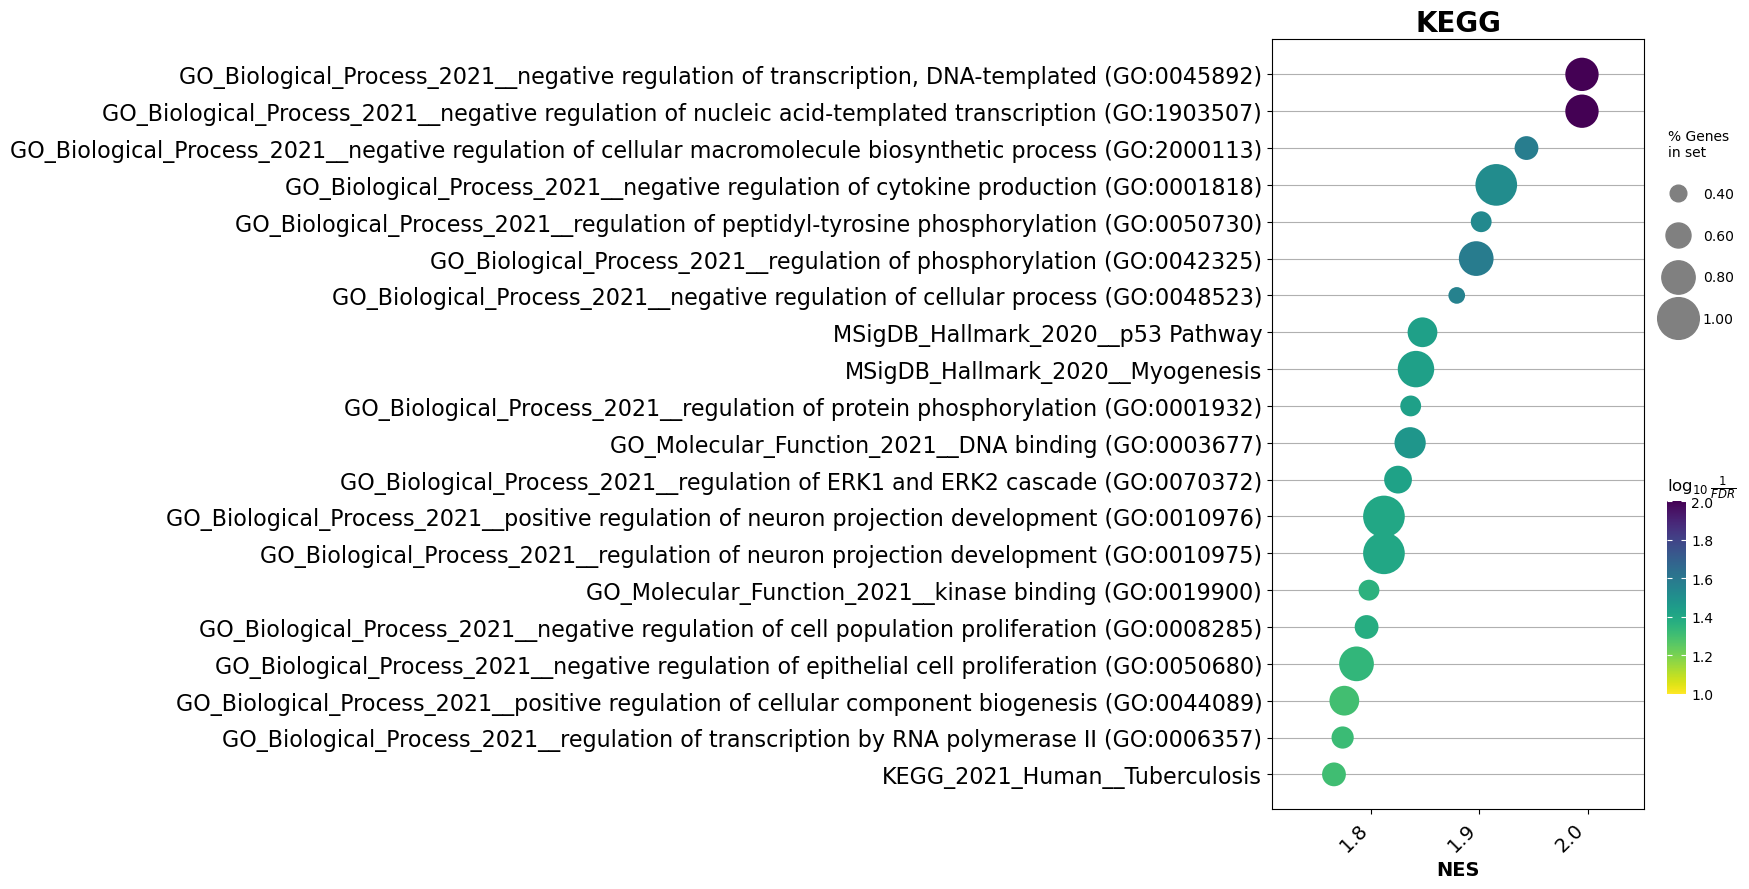

In [164]:
# categorical scatterplot
# ax = dotplot(pre_res,
#             column="NOM p-val",
#             # x='Name', # set x axis, so you could do a multi-sample/library comparsion
#             # dot_size="NES",
#             size=5,
#             top_term=20,
#             figsize=(6,10),
#             title = "KEGG",
#             xticklabels_rot=45, # rotate xtick labels
#             show_ring=False, # set to False to revmove outer ring
#             marker='o',
#              )

ax = dotplot(pre_res,
              column="FDR q-val",
              x='Gene_set', # set x axis, so you could do a multi-sample/library comparsion
              size=5,
              top_term=20,
              figsize=(6,10),
              title = "KEGG",
              xticklabels_rot=45, # rotate xtick labels
              show_ring=False, # set to False to revmove outer ring
              marker='o',
             )

### Trying concatenating all GSEA results into one dataframe for dotplotting

In [ ]:
from gseapy import barplot, dotplot

In [312]:
# Define additional new functions specific for concatenating GSEA results
def run_gsea_new(gene_rank_df, gene_sets, column_name):
    pre_res = gp.prerank(rnk=gene_rank_df,
                         gene_sets=gene_sets,
                         threads=4,
                         min_size=1,
                         max_size=1000,
                         permutation_num=1000,
                         outdir=None,
                         seed=6,
                         verbose=True)
    # pre_res = pre_res.res2d.sort_values(by='NES', ascending=False)
    pre_res = pre_res.res2d
    pre_res['CellType'] = column_name  # Add column for cell type
    print("success for", column_name)
    return pre_res


def process_columns_new(whole_coef_df, gene_sets, output_folder):
    LR_pairs_info = prepare_LR_pair_data(whole_coef_df)
    all_results = []  # List to collect all GSEA results

    for column_name, coeff_values in whole_coef_df.iloc[:, 1:].items():
        try:
            print(f"Processing cell type: {column_name}")
            LR_pair_data = combine_LR_pairs_with_coeff(LR_pairs_info, coeff_values)
            LR_rank_df = rank_LR_pairs(LR_pair_data)
            gene_rank_df = split_LR_pair_and_prepare_gene_rank(LR_rank_df)
            averaged_ranks_df = average_redundant_ranks(gene_rank_df)
            
            # Run GSEA and collect results
            gsea_results = run_gsea_new(averaged_ranks_df, gene_sets, column_name)
            all_results.append(gsea_results)
        except Exception as e:
            print(f"Error for column {column_name}: {e}")

    # Concatenate all results into a single DataFrame
    combined_results_df = pd.concat(all_results, ignore_index=True)
    # sort the results by NES value
    combined_results_df = combined_results_df.sort_values(by='NES', ascending=False)
    
    # Save the combined results to a CSV file
    combined_results_path = os.path.join(output_folder, "combined_gsea_results.csv")
    combined_results_df.to_csv(combined_results_path, index=False)
    print(f"Combined GSEA results saved to {combined_results_path}")

    return combined_results_df


In [313]:
combined_results_df = process_columns_new(whole_coef_df, gene_sets, output_folder)

2024-05-28 12:25:01,983 [WARNING] Duplicated values found in preranked stats: 14.10% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-05-28 12:25:01,983 [INFO] Parsing data files for GSEA.............................
2024-05-28 12:25:01,984 [INFO] Enrichr library gene sets already downloaded in: /Users/victoriagao/.cache/gseapy, use local file
2024-05-28 12:25:01,988 [INFO] Enrichr library gene sets already downloaded in: /Users/victoriagao/.cache/gseapy, use local file


Processing cell type: MT1X EC


2024-05-28 12:25:02,185 [ERROR] No supported gene_sets: MSigDB_C7
2024-05-28 12:25:02,189 [INFO] 0142 gene_sets have been filtered out when max_size=1000 and min_size=1
2024-05-28 12:25:02,189 [INFO] 0097 gene_sets used for further statistical testing.....
2024-05-28 12:25:02,189 [INFO] Start to run GSEA...Might take a while..................
2024-05-28 12:25:02,227 [INFO] Congratulations. GSEApy runs successfully................

2024-05-28 12:25:02,231 [WARNING] Duplicated values found in preranked stats: 15.38% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-05-28 12:25:02,231 [INFO] Parsing data files for GSEA.............................
2024-05-28 12:25:02,231 [INFO] Enrichr library gene sets already downloaded in: /Users/victoriagao/.cache/gseapy, use local file
2024-05-28 12:25:02,235 [INFO] Enrichr library gene sets already downloaded in: /Users/victoriagao/.cache/gseapy, use local file
2024-05-28 12:25:02,427 [ERROR] No supporte

success for MT1X EC
Processing cell type: Tip EC


2024-05-28 12:25:02,431 [INFO] 0142 gene_sets have been filtered out when max_size=1000 and min_size=1
2024-05-28 12:25:02,432 [INFO] 0097 gene_sets used for further statistical testing.....
2024-05-28 12:25:02,432 [INFO] Start to run GSEA...Might take a while..................
2024-05-28 12:25:02,466 [INFO] Congratulations. GSEApy runs successfully................

2024-05-28 12:25:02,470 [WARNING] Duplicated values found in preranked stats: 14.10% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-05-28 12:25:02,471 [INFO] Parsing data files for GSEA.............................
2024-05-28 12:25:02,471 [INFO] Enrichr library gene sets already downloaded in: /Users/victoriagao/.cache/gseapy, use local file
2024-05-28 12:25:02,474 [INFO] Enrichr library gene sets already downloaded in: /Users/victoriagao/.cache/gseapy, use local file
2024-05-28 12:25:02,666 [ERROR] No supported gene_sets: MSigDB_C7


success for Tip EC
Processing cell type: Venous EC


2024-05-28 12:25:02,671 [INFO] 0142 gene_sets have been filtered out when max_size=1000 and min_size=1
2024-05-28 12:25:02,671 [INFO] 0097 gene_sets used for further statistical testing.....
2024-05-28 12:25:02,671 [INFO] Start to run GSEA...Might take a while..................
2024-05-28 12:25:02,699 [INFO] Congratulations. GSEApy runs successfully................

2024-05-28 12:25:02,703 [WARNING] Duplicated values found in preranked stats: 15.38% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-05-28 12:25:02,703 [INFO] Parsing data files for GSEA.............................
2024-05-28 12:25:02,704 [INFO] Enrichr library gene sets already downloaded in: /Users/victoriagao/.cache/gseapy, use local file
2024-05-28 12:25:02,707 [INFO] Enrichr library gene sets already downloaded in: /Users/victoriagao/.cache/gseapy, use local file
2024-05-28 12:25:02,901 [ERROR] No supported gene_sets: MSigDB_C7


success for Venous EC
Processing cell type: EHT EC


2024-05-28 12:25:02,905 [INFO] 0142 gene_sets have been filtered out when max_size=1000 and min_size=1
2024-05-28 12:25:02,906 [INFO] 0097 gene_sets used for further statistical testing.....
2024-05-28 12:25:02,906 [INFO] Start to run GSEA...Might take a while..................
2024-05-28 12:25:02,933 [INFO] Congratulations. GSEApy runs successfully................

2024-05-28 12:25:02,937 [WARNING] Duplicated values found in preranked stats: 98.72% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-05-28 12:25:02,937 [INFO] Parsing data files for GSEA.............................
2024-05-28 12:25:02,938 [INFO] Enrichr library gene sets already downloaded in: /Users/victoriagao/.cache/gseapy, use local file
2024-05-28 12:25:02,940 [INFO] Enrichr library gene sets already downloaded in: /Users/victoriagao/.cache/gseapy, use local file


success for EHT EC
Processing cell type: Arterial EC


2024-05-28 12:25:03,136 [ERROR] No supported gene_sets: MSigDB_C7
2024-05-28 12:25:03,140 [INFO] 0142 gene_sets have been filtered out when max_size=1000 and min_size=1
2024-05-28 12:25:03,140 [INFO] 0097 gene_sets used for further statistical testing.....
2024-05-28 12:25:03,140 [INFO] Start to run GSEA...Might take a while..................
2024-05-28 12:25:03,173 [INFO] Congratulations. GSEApy runs successfully................

2024-05-28 12:25:03,177 [WARNING] Duplicated values found in preranked stats: 16.67% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-05-28 12:25:03,177 [INFO] Parsing data files for GSEA.............................
2024-05-28 12:25:03,177 [INFO] Enrichr library gene sets already downloaded in: /Users/victoriagao/.cache/gseapy, use local file
2024-05-28 12:25:03,180 [INFO] Enrichr library gene sets already downloaded in: /Users/victoriagao/.cache/gseapy, use local file
2024-05-28 12:25:03,372 [ERROR] No supporte

success for Arterial EC
Processing cell type: Normal Duct


2024-05-28 12:25:03,384 [INFO] 0142 gene_sets have been filtered out when max_size=1000 and min_size=1
2024-05-28 12:25:03,398 [INFO] 0097 gene_sets used for further statistical testing.....
2024-05-28 12:25:03,414 [INFO] Start to run GSEA...Might take a while..................
2024-05-28 12:25:03,760 [INFO] Congratulations. GSEApy runs successfully................

2024-05-28 12:25:03,777 [WARNING] Duplicated values found in preranked stats: 12.82% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-05-28 12:25:03,778 [INFO] Parsing data files for GSEA.............................
2024-05-28 12:25:03,779 [INFO] Enrichr library gene sets already downloaded in: /Users/victoriagao/.cache/gseapy, use local file
2024-05-28 12:25:03,811 [INFO] Enrichr library gene sets already downloaded in: /Users/victoriagao/.cache/gseapy, use local file


success for Normal Duct
Processing cell type: Acinar


2024-05-28 12:25:04,486 [ERROR] No supported gene_sets: MSigDB_C7
2024-05-28 12:25:04,637 [INFO] 0142 gene_sets have been filtered out when max_size=1000 and min_size=1
2024-05-28 12:25:04,639 [INFO] 0097 gene_sets used for further statistical testing.....
2024-05-28 12:25:04,640 [INFO] Start to run GSEA...Might take a while..................
2024-05-28 12:25:06,750 [INFO] Congratulations. GSEApy runs successfully................

2024-05-28 12:25:06,774 [WARNING] Duplicated values found in preranked stats: 17.95% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-05-28 12:25:06,776 [INFO] Parsing data files for GSEA.............................
2024-05-28 12:25:06,777 [INFO] Enrichr library gene sets already downloaded in: /Users/victoriagao/.cache/gseapy, use local file
2024-05-28 12:25:06,810 [INFO] Enrichr library gene sets already downloaded in: /Users/victoriagao/.cache/gseapy, use local file


success for Acinar
Processing cell type: Notta BasalA


2024-05-28 12:25:07,064 [ERROR] No supported gene_sets: MSigDB_C7
2024-05-28 12:25:07,078 [INFO] 0142 gene_sets have been filtered out when max_size=1000 and min_size=1
2024-05-28 12:25:07,079 [INFO] 0097 gene_sets used for further statistical testing.....
2024-05-28 12:25:07,080 [INFO] Start to run GSEA...Might take a while..................
2024-05-28 12:25:07,259 [INFO] Congratulations. GSEApy runs successfully................

2024-05-28 12:25:07,268 [WARNING] Duplicated values found in preranked stats: 14.10% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-05-28 12:25:07,272 [INFO] Parsing data files for GSEA.............................
2024-05-28 12:25:07,274 [INFO] Enrichr library gene sets already downloaded in: /Users/victoriagao/.cache/gseapy, use local file
2024-05-28 12:25:07,282 [INFO] Enrichr library gene sets already downloaded in: /Users/victoriagao/.cache/gseapy, use local file


success for Notta BasalA
Processing cell type: EMT Duct


2024-05-28 12:25:07,488 [ERROR] No supported gene_sets: MSigDB_C7
2024-05-28 12:25:07,495 [INFO] 0142 gene_sets have been filtered out when max_size=1000 and min_size=1
2024-05-28 12:25:07,496 [INFO] 0097 gene_sets used for further statistical testing.....
2024-05-28 12:25:07,496 [INFO] Start to run GSEA...Might take a while..................
2024-05-28 12:25:07,704 [INFO] Congratulations. GSEApy runs successfully................

2024-05-28 12:25:07,712 [WARNING] Duplicated values found in preranked stats: 14.10% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-05-28 12:25:07,713 [INFO] Parsing data files for GSEA.............................
2024-05-28 12:25:07,713 [INFO] Enrichr library gene sets already downloaded in: /Users/victoriagao/.cache/gseapy, use local file
2024-05-28 12:25:07,717 [INFO] Enrichr library gene sets already downloaded in: /Users/victoriagao/.cache/gseapy, use local file


success for EMT Duct
Processing cell type: Notta ClassicalA


2024-05-28 12:25:07,915 [ERROR] No supported gene_sets: MSigDB_C7
2024-05-28 12:25:07,921 [INFO] 0142 gene_sets have been filtered out when max_size=1000 and min_size=1
2024-05-28 12:25:07,922 [INFO] 0097 gene_sets used for further statistical testing.....
2024-05-28 12:25:07,922 [INFO] Start to run GSEA...Might take a while..................
2024-05-28 12:25:07,977 [INFO] Congratulations. GSEApy runs successfully................

2024-05-28 12:25:07,983 [WARNING] Duplicated values found in preranked stats: 14.10% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-05-28 12:25:07,983 [INFO] Parsing data files for GSEA.............................
2024-05-28 12:25:07,984 [INFO] Enrichr library gene sets already downloaded in: /Users/victoriagao/.cache/gseapy, use local file
2024-05-28 12:25:07,990 [INFO] Enrichr library gene sets already downloaded in: /Users/victoriagao/.cache/gseapy, use local file


success for Notta ClassicalA
Processing cell type: Metaplastic


2024-05-28 12:25:08,184 [ERROR] No supported gene_sets: MSigDB_C7
2024-05-28 12:25:08,187 [INFO] 0142 gene_sets have been filtered out when max_size=1000 and min_size=1
2024-05-28 12:25:08,188 [INFO] 0097 gene_sets used for further statistical testing.....
2024-05-28 12:25:08,188 [INFO] Start to run GSEA...Might take a while..................
2024-05-28 12:25:08,222 [INFO] Congratulations. GSEApy runs successfully................

2024-05-28 12:25:08,225 [WARNING] Duplicated values found in preranked stats: 11.54% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-05-28 12:25:08,226 [INFO] Parsing data files for GSEA.............................
2024-05-28 12:25:08,226 [INFO] Enrichr library gene sets already downloaded in: /Users/victoriagao/.cache/gseapy, use local file
2024-05-28 12:25:08,230 [INFO] Enrichr library gene sets already downloaded in: /Users/victoriagao/.cache/gseapy, use local file
2024-05-28 12:25:08,417 [ERROR] No supporte

success for Metaplastic
Processing cell type: HSP Duct


2024-05-28 12:25:08,452 [WARNING] Duplicated values found in preranked stats: 17.95% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-05-28 12:25:08,453 [INFO] Parsing data files for GSEA.............................
2024-05-28 12:25:08,453 [INFO] Enrichr library gene sets already downloaded in: /Users/victoriagao/.cache/gseapy, use local file
2024-05-28 12:25:08,456 [INFO] Enrichr library gene sets already downloaded in: /Users/victoriagao/.cache/gseapy, use local file


success for HSP Duct
Processing cell type: Notta BasalB


2024-05-28 12:25:08,661 [ERROR] No supported gene_sets: MSigDB_C7
2024-05-28 12:25:08,667 [INFO] 0142 gene_sets have been filtered out when max_size=1000 and min_size=1
2024-05-28 12:25:08,667 [INFO] 0097 gene_sets used for further statistical testing.....
2024-05-28 12:25:08,667 [INFO] Start to run GSEA...Might take a while..................
2024-05-28 12:25:08,700 [INFO] Congratulations. GSEApy runs successfully................

2024-05-28 12:25:08,704 [WARNING] Duplicated values found in preranked stats: 16.67% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-05-28 12:25:08,704 [INFO] Parsing data files for GSEA.............................
2024-05-28 12:25:08,704 [INFO] Enrichr library gene sets already downloaded in: /Users/victoriagao/.cache/gseapy, use local file
2024-05-28 12:25:08,707 [INFO] Enrichr library gene sets already downloaded in: /Users/victoriagao/.cache/gseapy, use local file


success for Notta BasalB
Processing cell type: Notta ClassicalB


2024-05-28 12:25:08,916 [ERROR] No supported gene_sets: MSigDB_C7
2024-05-28 12:25:08,919 [INFO] 0142 gene_sets have been filtered out when max_size=1000 and min_size=1
2024-05-28 12:25:08,920 [INFO] 0097 gene_sets used for further statistical testing.....
2024-05-28 12:25:08,920 [INFO] Start to run GSEA...Might take a while..................
2024-05-28 12:25:08,968 [INFO] Congratulations. GSEApy runs successfully................

2024-05-28 12:25:08,974 [WARNING] Duplicated values found in preranked stats: 15.38% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-05-28 12:25:08,975 [INFO] Parsing data files for GSEA.............................
2024-05-28 12:25:08,975 [INFO] Enrichr library gene sets already downloaded in: /Users/victoriagao/.cache/gseapy, use local file
2024-05-28 12:25:08,979 [INFO] Enrichr library gene sets already downloaded in: /Users/victoriagao/.cache/gseapy, use local file


success for Notta ClassicalB
Processing cell type: Early CD8


2024-05-28 12:25:09,171 [ERROR] No supported gene_sets: MSigDB_C7
2024-05-28 12:25:09,175 [INFO] 0142 gene_sets have been filtered out when max_size=1000 and min_size=1
2024-05-28 12:25:09,175 [INFO] 0097 gene_sets used for further statistical testing.....
2024-05-28 12:25:09,175 [INFO] Start to run GSEA...Might take a while..................
2024-05-28 12:25:09,208 [INFO] Congratulations. GSEApy runs successfully................

2024-05-28 12:25:09,212 [WARNING] Duplicated values found in preranked stats: 14.10% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-05-28 12:25:09,212 [INFO] Parsing data files for GSEA.............................
2024-05-28 12:25:09,212 [INFO] Enrichr library gene sets already downloaded in: /Users/victoriagao/.cache/gseapy, use local file
2024-05-28 12:25:09,216 [INFO] Enrichr library gene sets already downloaded in: /Users/victoriagao/.cache/gseapy, use local file
2024-05-28 12:25:09,409 [ERROR] No supporte

success for Early CD8
Processing cell type: Dysfunctional CD8


2024-05-28 12:25:09,413 [INFO] 0142 gene_sets have been filtered out when max_size=1000 and min_size=1
2024-05-28 12:25:09,413 [INFO] 0097 gene_sets used for further statistical testing.....
2024-05-28 12:25:09,413 [INFO] Start to run GSEA...Might take a while..................
2024-05-28 12:25:09,440 [INFO] Congratulations. GSEApy runs successfully................

2024-05-28 12:25:09,443 [WARNING] Duplicated values found in preranked stats: 14.10% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-05-28 12:25:09,443 [INFO] Parsing data files for GSEA.............................
2024-05-28 12:25:09,443 [INFO] Enrichr library gene sets already downloaded in: /Users/victoriagao/.cache/gseapy, use local file
2024-05-28 12:25:09,447 [INFO] Enrichr library gene sets already downloaded in: /Users/victoriagao/.cache/gseapy, use local file
2024-05-28 12:25:09,635 [ERROR] No supported gene_sets: MSigDB_C7
2024-05-28 12:25:09,639 [INFO] 0142 gene_se

success for Dysfunctional CD8
Processing cell type: Naive CD4 T Cell


2024-05-28 12:25:09,669 [WARNING] Duplicated values found in preranked stats: 12.82% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-05-28 12:25:09,669 [INFO] Parsing data files for GSEA.............................
2024-05-28 12:25:09,669 [INFO] Enrichr library gene sets already downloaded in: /Users/victoriagao/.cache/gseapy, use local file
2024-05-28 12:25:09,672 [INFO] Enrichr library gene sets already downloaded in: /Users/victoriagao/.cache/gseapy, use local file


success for Naive CD4 T Cell
Processing cell type: Progenitor Lymph


2024-05-28 12:25:09,869 [ERROR] No supported gene_sets: MSigDB_C7
2024-05-28 12:25:09,877 [INFO] 0142 gene_sets have been filtered out when max_size=1000 and min_size=1
2024-05-28 12:25:09,877 [INFO] 0097 gene_sets used for further statistical testing.....
2024-05-28 12:25:09,878 [INFO] Start to run GSEA...Might take a while..................
2024-05-28 12:25:09,970 [INFO] Congratulations. GSEApy runs successfully................

2024-05-28 12:25:09,974 [WARNING] Duplicated values found in preranked stats: 16.67% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-05-28 12:25:09,974 [INFO] Parsing data files for GSEA.............................
2024-05-28 12:25:09,974 [INFO] Enrichr library gene sets already downloaded in: /Users/victoriagao/.cache/gseapy, use local file
2024-05-28 12:25:09,978 [INFO] Enrichr library gene sets already downloaded in: /Users/victoriagao/.cache/gseapy, use local file
2024-05-28 12:25:10,170 [ERROR] No supporte

success for Progenitor Lymph
Processing cell type: Prolif Lymph


2024-05-28 12:25:10,176 [INFO] 0142 gene_sets have been filtered out when max_size=1000 and min_size=1
2024-05-28 12:25:10,176 [INFO] 0097 gene_sets used for further statistical testing.....
2024-05-28 12:25:10,176 [INFO] Start to run GSEA...Might take a while..................
2024-05-28 12:25:10,204 [INFO] Congratulations. GSEApy runs successfully................

2024-05-28 12:25:10,208 [WARNING] Duplicated values found in preranked stats: 20.51% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-05-28 12:25:10,208 [INFO] Parsing data files for GSEA.............................
2024-05-28 12:25:10,209 [INFO] Enrichr library gene sets already downloaded in: /Users/victoriagao/.cache/gseapy, use local file
2024-05-28 12:25:10,212 [INFO] Enrichr library gene sets already downloaded in: /Users/victoriagao/.cache/gseapy, use local file


success for Prolif Lymph
Processing cell type: Cytotoxic CD8 T


2024-05-28 12:25:10,410 [ERROR] No supported gene_sets: MSigDB_C7
2024-05-28 12:25:10,415 [INFO] 0142 gene_sets have been filtered out when max_size=1000 and min_size=1
2024-05-28 12:25:10,415 [INFO] 0097 gene_sets used for further statistical testing.....
2024-05-28 12:25:10,416 [INFO] Start to run GSEA...Might take a while..................
2024-05-28 12:25:10,445 [INFO] Congratulations. GSEApy runs successfully................

2024-05-28 12:25:10,449 [WARNING] Duplicated values found in preranked stats: 14.10% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-05-28 12:25:10,449 [INFO] Parsing data files for GSEA.............................
2024-05-28 12:25:10,449 [INFO] Enrichr library gene sets already downloaded in: /Users/victoriagao/.cache/gseapy, use local file
2024-05-28 12:25:10,453 [INFO] Enrichr library gene sets already downloaded in: /Users/victoriagao/.cache/gseapy, use local file
2024-05-28 12:25:10,645 [ERROR] No supporte

success for Cytotoxic CD8 T
Processing cell type: Mem B Cell


2024-05-28 12:25:10,651 [INFO] 0142 gene_sets have been filtered out when max_size=1000 and min_size=1
2024-05-28 12:25:10,651 [INFO] 0097 gene_sets used for further statistical testing.....
2024-05-28 12:25:10,652 [INFO] Start to run GSEA...Might take a while..................
2024-05-28 12:25:10,681 [INFO] Congratulations. GSEApy runs successfully................

2024-05-28 12:25:10,685 [WARNING] Duplicated values found in preranked stats: 20.51% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-05-28 12:25:10,685 [INFO] Parsing data files for GSEA.............................
2024-05-28 12:25:10,686 [INFO] Enrichr library gene sets already downloaded in: /Users/victoriagao/.cache/gseapy, use local file
2024-05-28 12:25:10,689 [INFO] Enrichr library gene sets already downloaded in: /Users/victoriagao/.cache/gseapy, use local file


success for Mem B Cell
Processing cell type: T Reg


2024-05-28 12:25:10,888 [ERROR] No supported gene_sets: MSigDB_C7
2024-05-28 12:25:10,896 [INFO] 0142 gene_sets have been filtered out when max_size=1000 and min_size=1
2024-05-28 12:25:10,896 [INFO] 0097 gene_sets used for further statistical testing.....
2024-05-28 12:25:10,897 [INFO] Start to run GSEA...Might take a while..................
2024-05-28 12:25:10,931 [INFO] Congratulations. GSEApy runs successfully................

2024-05-28 12:25:10,934 [WARNING] Duplicated values found in preranked stats: 11.54% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-05-28 12:25:10,935 [INFO] Parsing data files for GSEA.............................
2024-05-28 12:25:10,935 [INFO] Enrichr library gene sets already downloaded in: /Users/victoriagao/.cache/gseapy, use local file
2024-05-28 12:25:10,938 [INFO] Enrichr library gene sets already downloaded in: /Users/victoriagao/.cache/gseapy, use local file


success for T Reg
Processing cell type: Plasma


2024-05-28 12:25:11,135 [ERROR] No supported gene_sets: MSigDB_C7
2024-05-28 12:25:11,139 [INFO] 0142 gene_sets have been filtered out when max_size=1000 and min_size=1
2024-05-28 12:25:11,140 [INFO] 0097 gene_sets used for further statistical testing.....
2024-05-28 12:25:11,140 [INFO] Start to run GSEA...Might take a while..................
2024-05-28 12:25:11,165 [INFO] Congratulations. GSEApy runs successfully................

2024-05-28 12:25:11,169 [WARNING] Duplicated values found in preranked stats: 15.38% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-05-28 12:25:11,169 [INFO] Parsing data files for GSEA.............................
2024-05-28 12:25:11,169 [INFO] Enrichr library gene sets already downloaded in: /Users/victoriagao/.cache/gseapy, use local file
2024-05-28 12:25:11,173 [INFO] Enrichr library gene sets already downloaded in: /Users/victoriagao/.cache/gseapy, use local file


success for Plasma
Processing cell type: FSIP2 TAM


2024-05-28 12:25:11,371 [ERROR] No supported gene_sets: MSigDB_C7
2024-05-28 12:25:11,377 [INFO] 0142 gene_sets have been filtered out when max_size=1000 and min_size=1
2024-05-28 12:25:11,378 [INFO] 0097 gene_sets used for further statistical testing.....
2024-05-28 12:25:11,378 [INFO] Start to run GSEA...Might take a while..................
2024-05-28 12:25:11,409 [INFO] Congratulations. GSEApy runs successfully................

2024-05-28 12:25:11,412 [WARNING] Duplicated values found in preranked stats: 12.82% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-05-28 12:25:11,413 [INFO] Parsing data files for GSEA.............................
2024-05-28 12:25:11,413 [INFO] Enrichr library gene sets already downloaded in: /Users/victoriagao/.cache/gseapy, use local file
2024-05-28 12:25:11,416 [INFO] Enrichr library gene sets already downloaded in: /Users/victoriagao/.cache/gseapy, use local file


success for FSIP2 TAM
Processing cell type: Classical Mono


2024-05-28 12:25:11,619 [ERROR] No supported gene_sets: MSigDB_C7
2024-05-28 12:25:11,629 [INFO] 0142 gene_sets have been filtered out when max_size=1000 and min_size=1
2024-05-28 12:25:11,629 [INFO] 0097 gene_sets used for further statistical testing.....
2024-05-28 12:25:11,630 [INFO] Start to run GSEA...Might take a while..................
2024-05-28 12:25:11,665 [INFO] Congratulations. GSEApy runs successfully................

2024-05-28 12:25:11,669 [WARNING] Duplicated values found in preranked stats: 14.10% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-05-28 12:25:11,670 [INFO] Parsing data files for GSEA.............................
2024-05-28 12:25:11,670 [INFO] Enrichr library gene sets already downloaded in: /Users/victoriagao/.cache/gseapy, use local file
2024-05-28 12:25:11,673 [INFO] Enrichr library gene sets already downloaded in: /Users/victoriagao/.cache/gseapy, use local file


success for Classical Mono
Processing cell type: Resident Mac


2024-05-28 12:25:11,876 [ERROR] No supported gene_sets: MSigDB_C7
2024-05-28 12:25:11,883 [INFO] 0142 gene_sets have been filtered out when max_size=1000 and min_size=1
2024-05-28 12:25:11,884 [INFO] 0097 gene_sets used for further statistical testing.....
2024-05-28 12:25:11,884 [INFO] Start to run GSEA...Might take a while..................
2024-05-28 12:25:11,918 [INFO] Congratulations. GSEApy runs successfully................

2024-05-28 12:25:11,922 [WARNING] Duplicated values found in preranked stats: 16.67% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-05-28 12:25:11,922 [INFO] Parsing data files for GSEA.............................
2024-05-28 12:25:11,923 [INFO] Enrichr library gene sets already downloaded in: /Users/victoriagao/.cache/gseapy, use local file
2024-05-28 12:25:11,926 [INFO] Enrichr library gene sets already downloaded in: /Users/victoriagao/.cache/gseapy, use local file


success for Resident Mac
Processing cell type: mDC


2024-05-28 12:25:12,126 [ERROR] No supported gene_sets: MSigDB_C7
2024-05-28 12:25:12,136 [INFO] 0142 gene_sets have been filtered out when max_size=1000 and min_size=1
2024-05-28 12:25:12,137 [INFO] 0097 gene_sets used for further statistical testing.....
2024-05-28 12:25:12,137 [INFO] Start to run GSEA...Might take a while..................
2024-05-28 12:25:12,174 [INFO] Congratulations. GSEApy runs successfully................

2024-05-28 12:25:12,178 [WARNING] Duplicated values found in preranked stats: 12.82% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-05-28 12:25:12,179 [INFO] Parsing data files for GSEA.............................
2024-05-28 12:25:12,179 [INFO] Enrichr library gene sets already downloaded in: /Users/victoriagao/.cache/gseapy, use local file
2024-05-28 12:25:12,182 [INFO] Enrichr library gene sets already downloaded in: /Users/victoriagao/.cache/gseapy, use local file


success for mDC
Processing cell type: GRN TAM


2024-05-28 12:25:12,384 [ERROR] No supported gene_sets: MSigDB_C7
2024-05-28 12:25:12,392 [INFO] 0142 gene_sets have been filtered out when max_size=1000 and min_size=1
2024-05-28 12:25:12,392 [INFO] 0097 gene_sets used for further statistical testing.....
2024-05-28 12:25:12,393 [INFO] Start to run GSEA...Might take a while..................
2024-05-28 12:25:12,427 [INFO] Congratulations. GSEApy runs successfully................

2024-05-28 12:25:12,431 [WARNING] Duplicated values found in preranked stats: 17.95% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-05-28 12:25:12,431 [INFO] Parsing data files for GSEA.............................
2024-05-28 12:25:12,432 [INFO] Enrichr library gene sets already downloaded in: /Users/victoriagao/.cache/gseapy, use local file
2024-05-28 12:25:12,435 [INFO] Enrichr library gene sets already downloaded in: /Users/victoriagao/.cache/gseapy, use local file


success for GRN TAM
Processing cell type: SPP1 TAM


2024-05-28 12:25:12,629 [ERROR] No supported gene_sets: MSigDB_C7
2024-05-28 12:25:12,634 [INFO] 0142 gene_sets have been filtered out when max_size=1000 and min_size=1
2024-05-28 12:25:12,634 [INFO] 0097 gene_sets used for further statistical testing.....
2024-05-28 12:25:12,634 [INFO] Start to run GSEA...Might take a while..................
2024-05-28 12:25:12,658 [INFO] Congratulations. GSEApy runs successfully................

2024-05-28 12:25:12,661 [WARNING] Duplicated values found in preranked stats: 11.54% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-05-28 12:25:12,662 [INFO] Parsing data files for GSEA.............................
2024-05-28 12:25:12,662 [INFO] Enrichr library gene sets already downloaded in: /Users/victoriagao/.cache/gseapy, use local file
2024-05-28 12:25:12,665 [INFO] Enrichr library gene sets already downloaded in: /Users/victoriagao/.cache/gseapy, use local file


success for SPP1 TAM
Processing cell type: LAMP3 DC


2024-05-28 12:25:12,866 [ERROR] No supported gene_sets: MSigDB_C7
2024-05-28 12:25:12,874 [INFO] 0142 gene_sets have been filtered out when max_size=1000 and min_size=1
2024-05-28 12:25:12,875 [INFO] 0097 gene_sets used for further statistical testing.....
2024-05-28 12:25:12,875 [INFO] Start to run GSEA...Might take a while..................
2024-05-28 12:25:12,908 [INFO] Congratulations. GSEApy runs successfully................

2024-05-28 12:25:12,912 [WARNING] Duplicated values found in preranked stats: 16.67% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-05-28 12:25:12,912 [INFO] Parsing data files for GSEA.............................
2024-05-28 12:25:12,912 [INFO] Enrichr library gene sets already downloaded in: /Users/victoriagao/.cache/gseapy, use local file
2024-05-28 12:25:12,916 [INFO] Enrichr library gene sets already downloaded in: /Users/victoriagao/.cache/gseapy, use local file


success for LAMP3 DC
Processing cell type: myCAF


2024-05-28 12:25:13,112 [ERROR] No supported gene_sets: MSigDB_C7
2024-05-28 12:25:13,124 [INFO] 0142 gene_sets have been filtered out when max_size=1000 and min_size=1
2024-05-28 12:25:13,124 [INFO] 0097 gene_sets used for further statistical testing.....
2024-05-28 12:25:13,125 [INFO] Start to run GSEA...Might take a while..................
2024-05-28 12:25:13,160 [INFO] Congratulations. GSEApy runs successfully................

2024-05-28 12:25:13,164 [WARNING] Duplicated values found in preranked stats: 15.38% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-05-28 12:25:13,164 [INFO] Parsing data files for GSEA.............................
2024-05-28 12:25:13,165 [INFO] Enrichr library gene sets already downloaded in: /Users/victoriagao/.cache/gseapy, use local file
2024-05-28 12:25:13,168 [INFO] Enrichr library gene sets already downloaded in: /Users/victoriagao/.cache/gseapy, use local file


success for myCAF
Processing cell type: qPSC


2024-05-28 12:25:13,365 [ERROR] No supported gene_sets: MSigDB_C7
2024-05-28 12:25:13,370 [INFO] 0142 gene_sets have been filtered out when max_size=1000 and min_size=1
2024-05-28 12:25:13,370 [INFO] 0097 gene_sets used for further statistical testing.....
2024-05-28 12:25:13,371 [INFO] Start to run GSEA...Might take a while..................
2024-05-28 12:25:13,402 [INFO] Congratulations. GSEApy runs successfully................

2024-05-28 12:25:13,405 [WARNING] Duplicated values found in preranked stats: 16.67% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-05-28 12:25:13,406 [INFO] Parsing data files for GSEA.............................
2024-05-28 12:25:13,406 [INFO] Enrichr library gene sets already downloaded in: /Users/victoriagao/.cache/gseapy, use local file
2024-05-28 12:25:13,410 [INFO] Enrichr library gene sets already downloaded in: /Users/victoriagao/.cache/gseapy, use local file


success for qPSC
Processing cell type: smPSC


2024-05-28 12:25:13,637 [ERROR] No supported gene_sets: MSigDB_C7
2024-05-28 12:25:13,643 [INFO] 0142 gene_sets have been filtered out when max_size=1000 and min_size=1
2024-05-28 12:25:13,643 [INFO] 0097 gene_sets used for further statistical testing.....
2024-05-28 12:25:13,643 [INFO] Start to run GSEA...Might take a while..................
2024-05-28 12:25:13,673 [INFO] Congratulations. GSEApy runs successfully................

2024-05-28 12:25:13,677 [WARNING] Duplicated values found in preranked stats: 19.23% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-05-28 12:25:13,678 [INFO] Parsing data files for GSEA.............................
2024-05-28 12:25:13,678 [INFO] Enrichr library gene sets already downloaded in: /Users/victoriagao/.cache/gseapy, use local file
2024-05-28 12:25:13,681 [INFO] Enrichr library gene sets already downloaded in: /Users/victoriagao/.cache/gseapy, use local file


success for smPSC
Processing cell type: Myocyte


2024-05-28 12:25:13,877 [ERROR] No supported gene_sets: MSigDB_C7
2024-05-28 12:25:13,882 [INFO] 0142 gene_sets have been filtered out when max_size=1000 and min_size=1
2024-05-28 12:25:13,882 [INFO] 0097 gene_sets used for further statistical testing.....
2024-05-28 12:25:13,882 [INFO] Start to run GSEA...Might take a while..................
2024-05-28 12:25:13,910 [INFO] Congratulations. GSEApy runs successfully................

2024-05-28 12:25:13,914 [WARNING] Duplicated values found in preranked stats: 16.67% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-05-28 12:25:13,914 [INFO] Parsing data files for GSEA.............................
2024-05-28 12:25:13,915 [INFO] Enrichr library gene sets already downloaded in: /Users/victoriagao/.cache/gseapy, use local file
2024-05-28 12:25:13,918 [INFO] Enrichr library gene sets already downloaded in: /Users/victoriagao/.cache/gseapy, use local file


success for Myocyte
Processing cell type: csCAF


2024-05-28 12:25:14,118 [ERROR] No supported gene_sets: MSigDB_C7
2024-05-28 12:25:14,125 [INFO] 0142 gene_sets have been filtered out when max_size=1000 and min_size=1
2024-05-28 12:25:14,126 [INFO] 0097 gene_sets used for further statistical testing.....
2024-05-28 12:25:14,126 [INFO] Start to run GSEA...Might take a while..................
2024-05-28 12:25:14,159 [INFO] Congratulations. GSEApy runs successfully................

2024-05-28 12:25:14,163 [WARNING] Duplicated values found in preranked stats: 16.67% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-05-28 12:25:14,163 [INFO] Parsing data files for GSEA.............................
2024-05-28 12:25:14,163 [INFO] Enrichr library gene sets already downloaded in: /Users/victoriagao/.cache/gseapy, use local file
2024-05-28 12:25:14,167 [INFO] Enrichr library gene sets already downloaded in: /Users/victoriagao/.cache/gseapy, use local file


success for csCAF
Processing cell type: IL11 CAF


2024-05-28 12:25:14,371 [ERROR] No supported gene_sets: MSigDB_C7
2024-05-28 12:25:14,380 [INFO] 0142 gene_sets have been filtered out when max_size=1000 and min_size=1
2024-05-28 12:25:14,380 [INFO] 0097 gene_sets used for further statistical testing.....
2024-05-28 12:25:14,380 [INFO] Start to run GSEA...Might take a while..................
2024-05-28 12:25:14,414 [INFO] Congratulations. GSEApy runs successfully................



success for IL11 CAF
Combined GSEA results saved to /Users/victoriagao/local_docs/NEST/stored_variables/GSEA/5.28_from_new_MNL_coeff/combined_gsea_results.csv


In [314]:
# get the first 50 rows of the combined results
combined_results_top50 = combined_results_df.head(50)

In [315]:
combined_results_top50

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes,CellType
389,prerank,MSigDB_Oncogenic_Signatures__PIGF UP.V1 UP,0.786667,1.768901,0.026365,0.183815,0.125,3/3,24.36%,ADAM9;AIMP1;TTR,Arterial EC
390,prerank,MSigDB_Oncogenic_Signatures__VEGF A UP.V1 DN,0.947368,1.763875,0.011299,0.095954,0.129,2/2,7.69%,ADAM9;AIMP1,Arterial EC
873,prerank,MSigDB_Oncogenic_Signatures__CAMP UP.V1 UP,0.920402,1.761964,0.005797,0.040232,0.044,2/3,3.85%,HSP90B1;ARF1,Notta ClassicalA
2619,prerank,MSigDB_Hallmark_2020__PI3K/AKT/mTOR Signaling,0.920197,1.76063,0.001433,0.044511,0.035,2/3,8.97%,ARF1;CALR,GRN TAM
195,prerank,MSigDB_Oncogenic_Signatures__CAMP UP.V1 UP,0.88,1.736121,0.005618,0.069317,0.067,3/3,15.38%,ARF1;HMGB2;HSP90B1,Venous EC
1552,prerank,MSigDB_Hallmark_2020__Coagulation,0.71184,1.688169,0.023166,0.101171,0.104,3/5,14.10%,TIMP1;THBS1;FN1,Naive CD4 T Cell
196,prerank,MSigDB_Hallmark_2020__Complement,0.665332,1.66186,0.014379,0.072127,0.131,4/6,17.95%,CALM1;TIMP1;FN1;SERPINA1,Venous EC
1067,prerank,MSigDB_Hallmark_2020__PI3K/AKT/mTOR Signaling,0.874903,1.657465,0.01037,0.130896,0.101,2/3,5.13%,ARF1;HSP90B1,HSP Duct
776,prerank,MSigDB_Hallmark_2020__Inflammatory Response,0.962025,1.600841,0.001608,0.249024,0.181,1/2,1.28%,CX3CL1,EMT Duct
582,prerank,MSigDB_Oncogenic_Signatures__PIGF UP.V1 UP,0.84,1.579384,0.013062,0.306505,0.215,3/3,19.23%,ADAM9;TTR;AIMP1,Acinar


In [316]:
# Use regular expression to remove prefix of gene set names (e.g. "MSigDB_Hallmark_2020__" or "MSigDB_Oncogenic_Signatures__")
combined_results_df['Term'] = combined_results_df['Term'].str.replace(r'MSigDB_Hallmark_2020__', '')
combined_results_df['Term'] = combined_results_df['Term'].str.replace(r'MSigDB_Oncogenic_Signatures__', '')


In [317]:
combined_results_df

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes,CellType
389,prerank,PIGF UP.V1 UP,0.786667,1.768901,0.026365,0.183815,0.125,3/3,24.36%,ADAM9;AIMP1;TTR,Arterial EC
390,prerank,VEGF A UP.V1 DN,0.947368,1.763875,0.011299,0.095954,0.129,2/2,7.69%,ADAM9;AIMP1,Arterial EC
873,prerank,CAMP UP.V1 UP,0.920402,1.761964,0.005797,0.040232,0.044,2/3,3.85%,HSP90B1;ARF1,Notta ClassicalA
2619,prerank,PI3K/AKT/mTOR Signaling,0.920197,1.76063,0.001433,0.044511,0.035,2/3,8.97%,ARF1;CALR,GRN TAM
195,prerank,CAMP UP.V1 UP,0.88,1.736121,0.005618,0.069317,0.067,3/3,15.38%,ARF1;HMGB2;HSP90B1,Venous EC
...,...,...,...,...,...,...,...,...,...,...,...
291,prerank,VEGF A UP.V1 DN,-1.0,-1.685699,0.002747,0.080801,0.071,2/2,3.85%,AIMP1;ADAM9,EHT EC
1164,prerank,Apical Junction,-0.72973,-1.732296,0.037915,0.05785,0.042,4/4,32.05%,ADAM9;LAMC2;CX3CL1;ITGB1,Notta BasalB
388,prerank,Allograft Rejection,-0.826667,-1.773353,0.021097,0.099629,0.106,3/3,21.79%,TIMP1;RPS19;TGFB1,Arterial EC
3298,prerank,PIGF UP.V1 UP,-0.906667,-1.785158,0.0,0.028911,0.021,3/3,14.10%,AIMP1;TTR;ADAM9,csCAF


/Users/victoriagao/anaconda3/lib/python3.11/site-packages/gseapy/plot.py:694: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df[self.colname].replace(
/Users/victoriagao/anaconda3/lib/python3.11/site-packages/gseapy/plot.py:694: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[self.colname].replace(


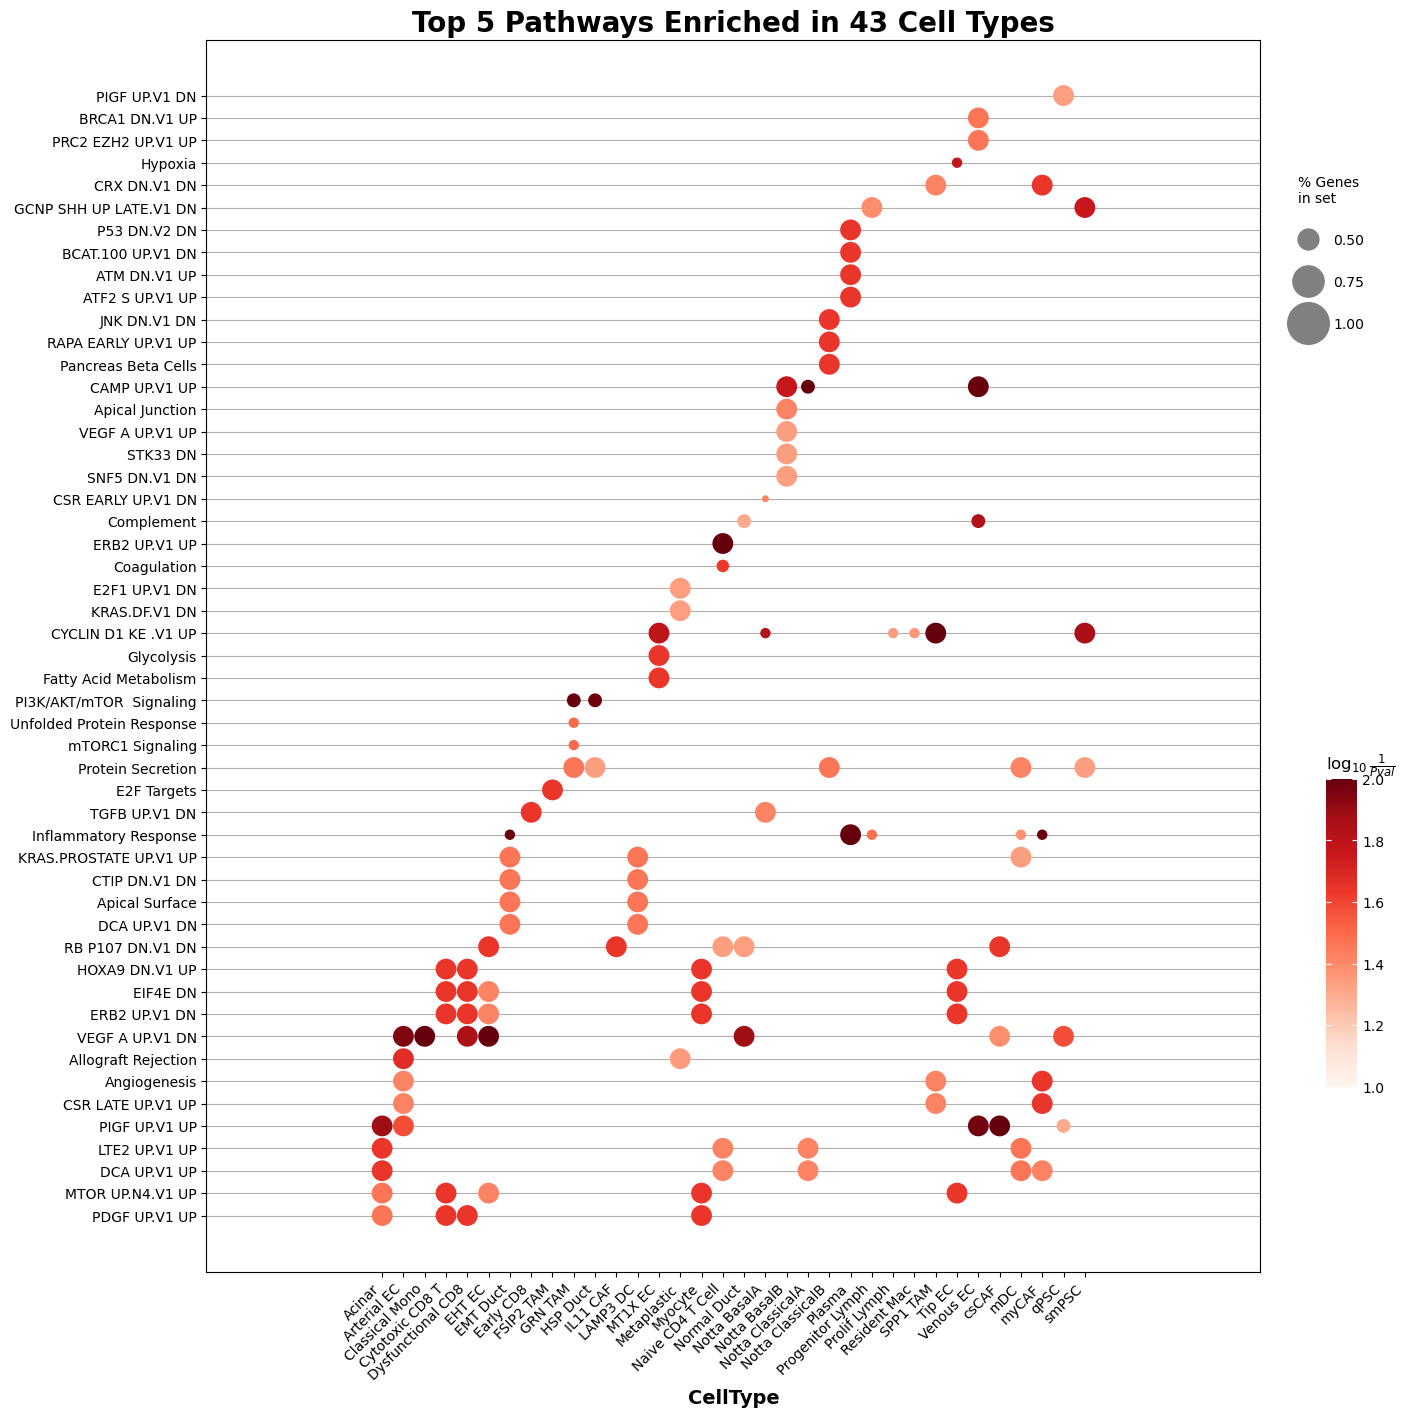

: 

In [347]:
# ax = dotplot(combined_results_df,
#              column="FDR q-val",
#              title='KEGG_2016',
#             #  cmap=plt.cm.viridis,
#              size=6, # adjust dot size
#              figsize=(4,5), cutoff=0.25, show_ring=False)

dotplot_combined = dotplot(combined_results_df,
              column="NOM p-val",
              # hue='CellType',
              x='CellType', # set x axis, so you could do a multi-sample/library comparsion
              size=5,
              cmap="Reds",
              top_term=5,
              figsize=(17,16),
              title = "Top 5 Pathways Enriched in 43 Cell Types",
              xticklabels_rot=45, # rotate xtick labels
              show_ring=False, # set to False to revmove outer ring
              marker='.'
             )

for label in dotplot_combined.get_yticklabels():
    label.set_fontsize(10)  # Set to desired font size

for label in dotplot_combined.get_xticklabels():
    label.set_fontsize(10)

In [322]:
# Trying to rotate the whole figure, not working

# dotplot_combined = dotplot(combined_results_df,
#                            column="NOM p-val",
#                            x='Term', # Set x to terms
#                         #    hue='CellType', # Set hue to CellType to differentiate cell types
#                            y='CellType',
#                            size=5,
#                            cmap="Reds",
#                            top_term=5,
#                            figsize=(16,13), # Adjust figsize to account for flipped axes
#                            title="Top 5 Pathways Enriched in 15 Cell Types",
#                            xticklabels_rot=45, # Rotate x-tick labels
#                            show_ring=False, # Remove outer ring
#                            marker='.',
#                           )